In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import networkx as nx

import sys

In [2]:
sys.path.append('../')

In [3]:
from common_functions import eval_g_hat_with_DnX

In [4]:
p2root = '../results_0905_logging/'
K = 25
version='Rr'
iteration = 10000
iid_sample = 20000
chromo = 'chr2L'
expr_name = f'{chromo}_drosophila_ChIA_Drop_0.1_PASS'
prefix = f'{expr_name}_{iid_sample}_MCMC_pivot_K_{K}_iter_{iteration}'
# prefix = f'{expr_name}_{iid_sample}_K_{K}_iter_{iteration}'
# p2nmf_dict = osp.join(p2root, f'{prefix}_nmf_centroid_df')
# p2cmf_dict = osp.join(p2root, f'{prefix}_cmf_centroid_df')
# p2omf_dict = osp.join(p2root, f'{prefix}_omf_centroid_df')

p2ocmf_dict = osp.join(p2root, f'{version}_{prefix}_ocmf_centroid_df')
p2representative_regions = osp.join(p2root, f'{version}_{prefix}_x_hat_df')
p2A_t = osp.join(p2root, f'A_t_{version}_{prefix}_ocmf.csv')
p2W_hat = osp.join(p2root, f'W_hat_{version}_{prefix}_ocmf.csv')
p2X = osp.join(p2root, f'{prefix}_X_df')

In [5]:
X_df = pd.read_pickle(p2X)
# nmf_dict = pd.read_pickle(p2nmf_dict)
# cmf_dict = pd.read_pickle(p2cmf_dict)
# omf_dict = pd.read_pickle(p2omf_dict)
ocmf_dict = pd.read_pickle(p2ocmf_dict)
rep_region = pd.read_pickle(p2representative_regions)

In [6]:
W_hat = np.loadtxt(p2W_hat, delimiter=',')
A_t = np.loadtxt(p2A_t, delimiter=',')

In [7]:
(W_hat > 0).astype(int)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [8]:
rep_region.label.value_counts()

group 2     36
group 21    32
group 6     24
group 8     22
group 7     21
group 5     20
group 0     19
group 22    17
group 12    14
group 17    12
group 14    12
group 18    12
group 4     12
group 3     11
group 15    11
group 10    10
group 13    10
group 23    10
group 16    10
group 19    10
group 9     10
group 1     10
group 20    10
group 24    10
group 11    10
Name: label, dtype: int64

In [9]:
def plot_one_row(ax, row, k = 21, threshold = 1, title = ''):
    row_np = np.array(row)
    if threshold is not None:
        bin_row = (row_np >= threshold).astype(int)
        bin_row_mat = bin_row.reshape(k, k)
    else:
        bin_row_mat = row_np.reshape(k, k)
    
    ax.imshow(bin_row_mat, cmap = 'Greys')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return bin_row_mat, ax

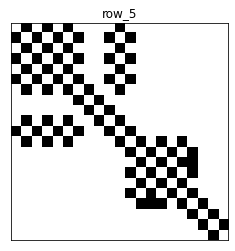

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_one_row(ax, X_df.loc[5], title = 'row_5')
plt.show()
plt.close()

In [11]:
def plot_df_in_grid(df_in, grid_size = (2, 5), figsize = (10, 4), 
                    k = 21, threshold = 1, title_prefix = 'row', title = '', 
                   sub_titles = None, p2savefig = None):
    fig = plt.figure(figsize = figsize)
    axes = fig.subplots((*grid_size))
    
    for row_idx in range(grid_size[0]):
        for col_idx in range(grid_size[1]):
            ax = axes[row_idx][col_idx]
            
            idx = row_idx * grid_size[1] + col_idx
            if idx < df_in.shape[0]:
                cur_row = df_in.iloc[idx]
            else:
                cur_row = np.zeros_like(df_in.iloc[0].values)
            
            if sub_titles is None:
                subtitle =  f'{title_prefix}_{idx}'
            else:
                if idx < len(sub_titles):
                    subtitle = sub_titles[idx]
                else:
                    subtitle = ''
                
            plot_one_row(ax, cur_row, k = k, threshold= threshold, title = subtitle)
    plt.suptitle(title, y = 1.05)
    plt.tight_layout()
    
    if p2savefig is None:
        plt.show()    
        plt.close()
    else:
        plt.savefig(p2savefig)
        plt.close()

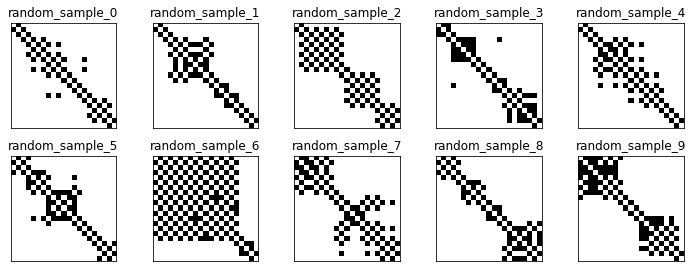

In [12]:
plot_df_in_grid(X_df.loc[np.random.choice(X_df.index, 10)], title_prefix= 'random_sample')

# online cvxMF results

<AxesSubplot:>

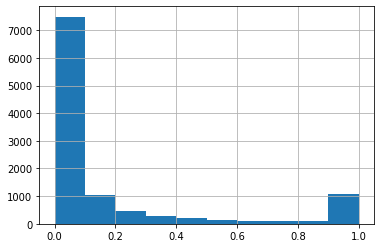

In [13]:
feature = [x for x in ocmf_dict.columns if 'label' not in x]
ocmf_dict_val_df = ocmf_dict[feature]
ocmf_dict_val_df.stack().hist()

In [14]:
def get_importance_from_At(A_t):
    diag = A_t.diagonal()
    sum_diag = sum(diag)
    score = diag / sum_diag
    return score

In [15]:
importance_score = get_importance_from_At(A_t)
subtitles = [f'online cvxNDL\n dictionaries {x}\n score {importance_score[x]:.2f}' for x in range(ocmf_dict_val_df.shape[0])]

In [16]:
descending_order_of_At = importance_score.argsort()[::-1]

In [17]:
importance_score[descending_order_of_At]

array([0.0845453 , 0.07691876, 0.07449854, 0.070208  , 0.06057809,
       0.05941527, 0.05704141, 0.05465686, 0.04649116, 0.04472002,
       0.0444476 , 0.03762764, 0.03031203, 0.0301816 , 0.02951749,
       0.02888147, 0.02537849, 0.02424211, 0.02212079, 0.01929306,
       0.01761369, 0.01650967, 0.01629379, 0.01426645, 0.01424071])

In [18]:
# plot_df_in_grid(ocmf_dict_val_df, threshold = 0.6, 
#                 grid_size = (5, 5), figsize = (10, 10),
#                 sub_titles= subtitles,
#                 title = 'online cvxNDL')

## sorted dictionary by importance score

In [19]:
sorted_ocmf_dict_val_df_by_At = ocmf_dict_val_df.loc[descending_order_of_At]
sorted_subtitles_by_At = [subtitles[i] for i in descending_order_of_At]

### Binarized dictionaries

In [20]:
# p2saved = f'/data/shared/jianhao/online_cvxNDL_results/{chromo}'
# if not osp.isdir(p2saved):
#     os.makedirs(p2saved)
    
# plot_df_in_grid(sorted_ocmf_dict_val_df_by_At, threshold = 0.6, 
#                 grid_size = (5, 5), figsize = (10, 10),
#                 sub_titles= sorted_subtitles_by_At,
#                 title = 'online cvxNDL',
#                p2savefig=osp.join(p2saved, f'{chromo}_all_dictionaries_updated_0905'))

### raw dicitonaries 

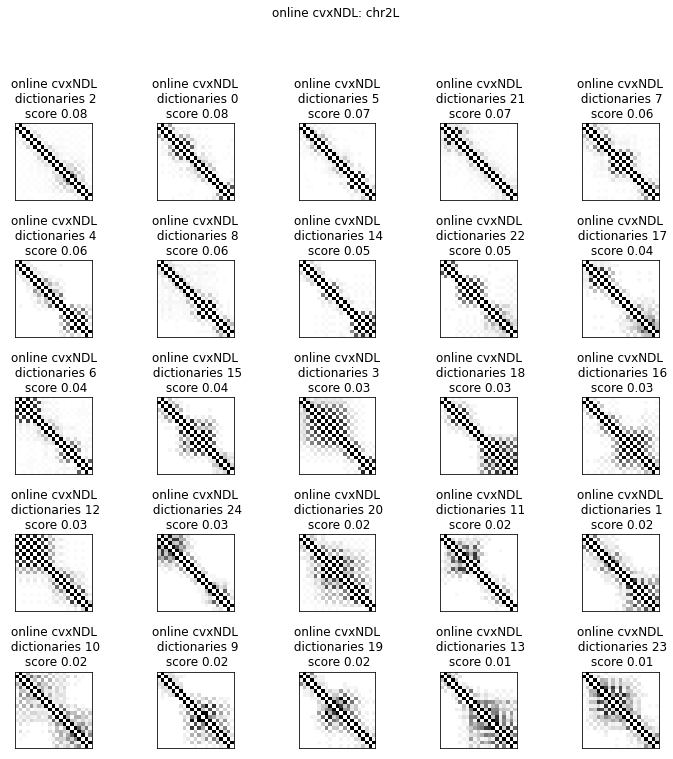

In [21]:
plot_df_in_grid(sorted_ocmf_dict_val_df_by_At, threshold = None, 
                grid_size = (5, 5), figsize = (10, 10),
                sub_titles= sorted_subtitles_by_At,
                title = f'online cvxNDL: {chromo}')

## plot convex hull of representative regions

In [22]:
def plot_cvx_hull(ax, df_in, weight = None, k = 21, title = ''):
#     fig = plt.figure()
#     ax = fig.subplots()
    
    if weight is None:
        average_row = df_in.mean(axis = 0).values
    else:
        average_row = (df_in * weight.reshape(-1, 1)).sum(axis = 0).values
    bin_row_mat = average_row.reshape(k, k)

    ax.imshow(bin_row_mat, cmap = 'Greys')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

#     plt.show()
#     plt.close()
    return ax

In [23]:
df_W_hat = pd.DataFrame(data = W_hat, columns = [f'w_cluster_{x}' for x in range(W_hat.shape[1])])

In [24]:
df_W_hat

,w_cluster_0,w_cluster_1,w_cluster_2,w_cluster_3,w_cluster_4,w_cluster_5,w_cluster_6,w_cluster_7,w_cluster_8,w_cluster_9,...,w_cluster_15,w_cluster_16,w_cluster_17,w_cluster_18,w_cluster_19,w_cluster_20,w_cluster_21,w_cluster_22,w_cluster_23,w_cluster_24
0,0.058095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.047625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.032210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.058110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.057509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120078
371,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108379
372,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103790
373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090200


In [25]:
descending_order_of_At

array([ 2,  0,  5, 21,  7,  4,  8, 14, 22, 17,  6, 15,  3, 18, 16, 12, 24,
       20, 11,  1, 10,  9, 19, 13, 23])

## Plot dictionaries in importance score order. Also plot the representative regions by their weights

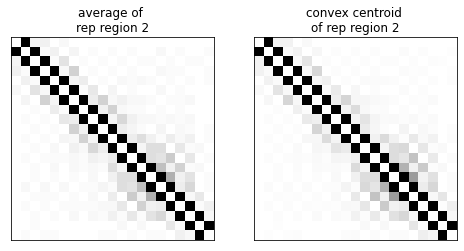

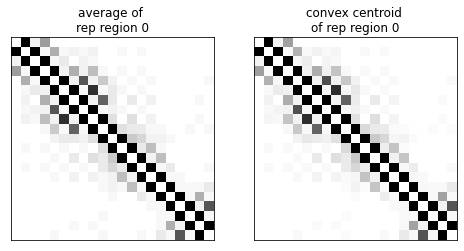

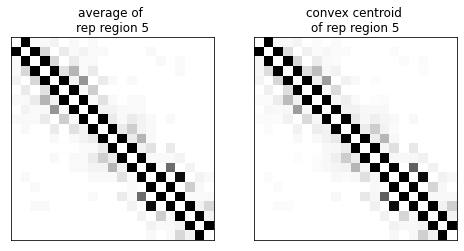

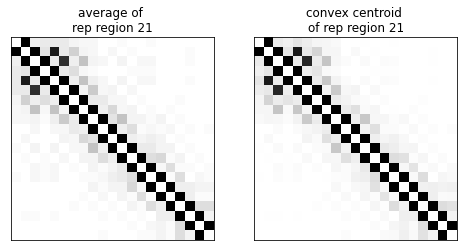

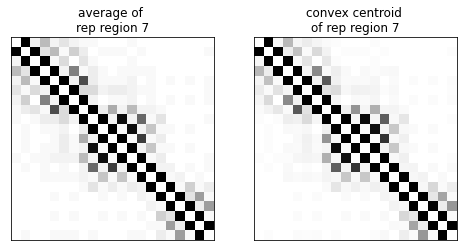

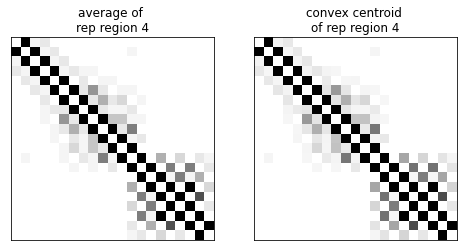

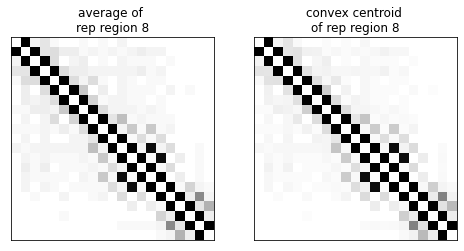

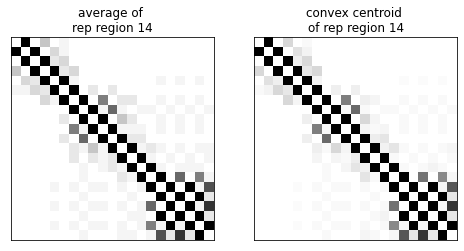

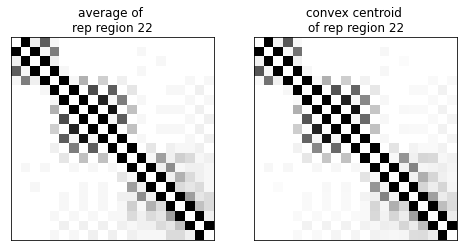

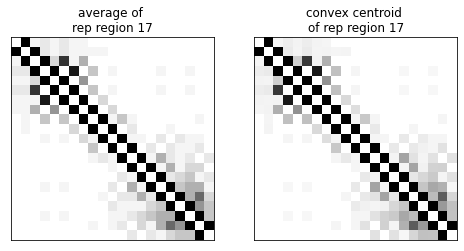

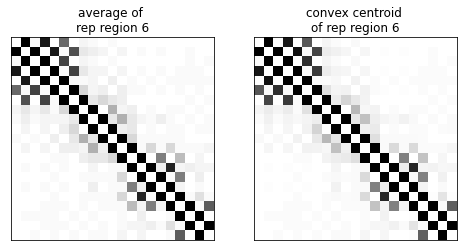

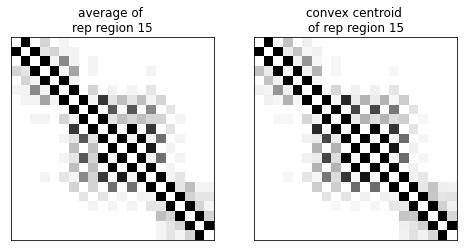

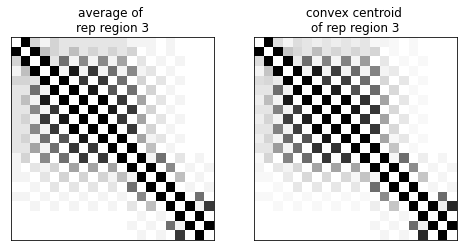

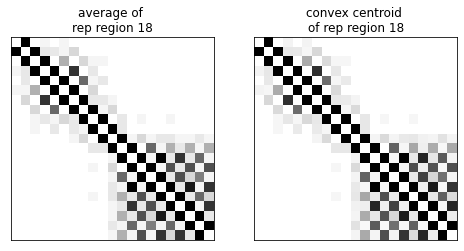

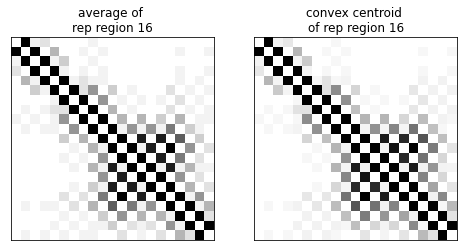

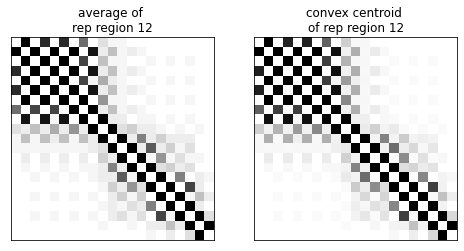

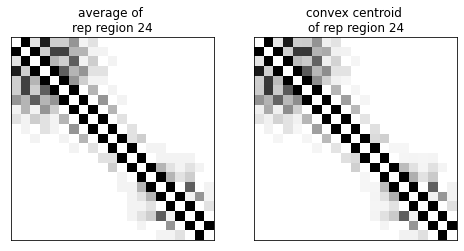

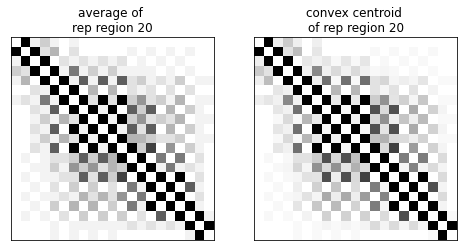

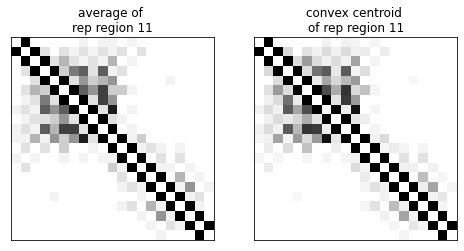

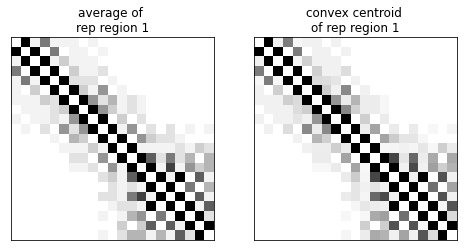

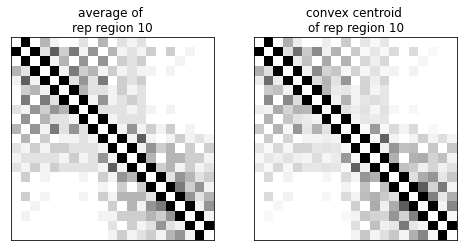

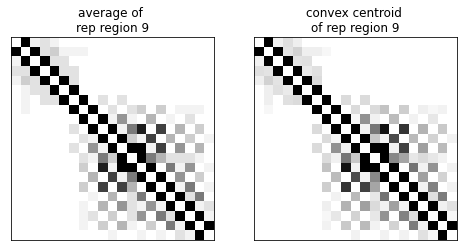

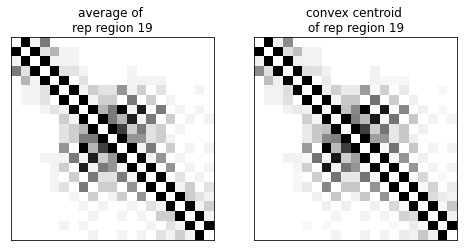

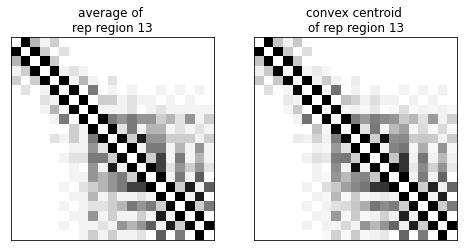

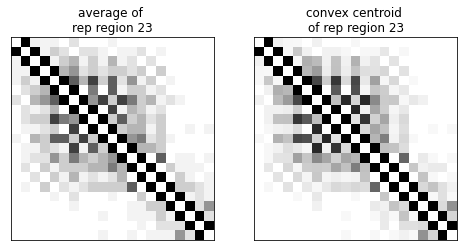

In [26]:
for i in descending_order_of_At:
    cur_label = f'group {i}'
    df_rep = rep_region[rep_region.label == cur_label]
    df_rep_val_df = df_rep[feature]

    dict_row = ocmf_dict[ocmf_dict.label == f'ocmf: type {i + 1}']
    dict_row = dict_row[feature]
    fig = plt.figure(figsize=(8, 40))
    ax = fig.subplots(1, 2)
    # plot the dictionary, which is also the convex centroid.
#     plot_one_row(ax[0], row = dict_row, 
#                  title = f'online cvxMF \ndictionary {i}\nscore = {importance_score[i]:.2f}', 
#                  threshold= 0.8)
    # plot the average of representatives. 
    plot_cvx_hull(ax[0], df_rep_val_df, weight = None,
                 title = f'average of \nrep region {i}')
    
    cvx_weight = df_W_hat[rep_region.label == cur_label].values[:, i]
    descending_order_cvx_weight = cvx_weight.argsort()[::-1]
    
    plot_cvx_hull(ax[1], df_rep_val_df, weight = cvx_weight,
                  title = f'convex centroid \nof rep region {i}')
#     plot_cvx_hull(ax[2], df_rep_val_df, weight = None,
#                   title = f'cvx hull \nof rep region {i}')

    plt.show()

    plt.close()
    
    sub_titles = [f'rep_{x}, \nweight = {cvx_weight[x]:.2f}' \
                  for x in descending_order_cvx_weight]
    
    # reorder df_rep by their weights
    sorted_df_rep_val_df_by_cvx_weight = df_rep_val_df.iloc[descending_order_cvx_weight]
    
    p2saved = f'/data/shared/jianhao/online_cvxNDL_results/{chromo}'
    if not osp.isdir(p2saved):
        os.makedirs(p2saved)
    plot_df_in_grid(sorted_df_rep_val_df_by_cvx_weight.head(10), threshold = 1, 
                    sub_titles = sub_titles, title = f'dictionary {i}', 
                   p2savefig= osp.join(p2saved, f'representatives_of_dictionary_{i}_updated_0905_MCMC_pivot'))
#     break
    

------
# Get subgraph node embeddings

In [27]:
expr_name, iid_sample

('chr2L_drosophila_ChIA_Drop_0.1_PASS', 20000)

In [28]:
# p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/new_data_with_node_id/'
# p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/updated_0905_data_with_node_id/'

# p2emb = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_sample_node_matrix')
# p2raw_data = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}')

p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/updated_0905_data_with_node_id'
p2emb = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_MCMC_pivot_sample_node_matrix')
p2raw_data = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_MCMC_pivot')

In [29]:
df_node_all = pd.read_pickle(p2emb)
df_subgraph_all = pd.read_pickle(p2raw_data).drop(columns = ['label'])
# df_subgraph_all_old = pd.read_pickle(p2raw_data_old).drop(columns = ['label'])

In [30]:
# df_node_all = df_node_all.applymap(lambda s: s.replace('"', ''))

In [31]:
df_node_all

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,node_11,node_12,node_13,node_14,node_15,node_16,node_17,node_18,node_19,node_20
0,V5997,V19835,V969,V961,V2405,V20728,V20814,V20728,V26131,V20728,...,V20728,V27017,V6131,V11815,V4455,V11815,V6131,V4455,V27017,V27025
1,V41207,V22040,V41207,V22040,V41207,V22040,V36348,V41207,V22040,V20407,...,V4078,V186,V250,V135,V14276,V135,V19913,V135,V186,V153
2,V13615,V16412,V16377,V14431,V16377,V16412,V16400,V16412,V16256,V14432,...,V44859,V41989,V14432,V15932,V41989,V15932,V27666,V41754,V41780,V41767
3,V7474,V7462,V87,V16766,V2911,V1000,V1035,V35092,V35449,V35092,...,V6371,V35017,V1035,V1000,V954,V19311,V9257,V42290,V42241,V34944
4,V7474,V7462,V5357,V4394,V5357,V7462,V7497,V16411,V39787,V500,...,V39428,V39553,V39351,V39428,V25400,V25623,V258,V27057,V34954,V3538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,V39624,V42442,V2820,V18992,V7395,V18992,V16630,V12679,V1020,V1083,...,V36334,V4157,V36334,V37139,V969,V16023,V969,V35164,V969,V218
19996,V26447,V27659,V27672,V19229,V43360,V34901,V324,V6740,V324,V32512,...,V16411,V27231,V26418,V10942,V20765,V32906,V32787,V33273,V41480,V31699
19997,V39599,V9995,V38842,V16847,V4306,V1057,V985,V42527,V42478,V13003,...,V29664,V33223,V33250,V27114,V27156,V20854,V20824,V33868,V20856,V14348
19998,V39954,V9995,V10131,V9998,V27680,V9998,V1665,V1656,V1665,V1644,...,V38189,V1280,V2259,V18030,V2259,V2117,V2243,V2117,V2259,V2251


### check which dataset used in training.
if use old subgraph, then subgraph may not have correponding node embeddings.


In [32]:
# if (X_df.values == df_subgraph_all_old.values).all():
#     print('>>> used old dataset without node embedding!!!! Change later on.')
#     df_raw_data = df_subgraph_all_old
#     warning_flag = True
#     df_raw_data_matched_emb = df_subgraph_all
    
if (X_df.values == df_subgraph_all.values).all():
    print('>>> used new dataset with node embeddings. GOOD to go.')
    df_raw_data = df_subgraph_all
    warning_flag = False
    df_raw_data_matched_emb = df_subgraph_all

>>> used new dataset with node embeddings. GOOD to go.


### 1. df_raw_data will always be the input data. So df_rep.isin(df_raw_data) == True. 
only case is that when used old data:

=> **df_node_emb** and **df_raw_data** does not match. 

### 2. df_raw_data_matched_emb will always matched the node embedding

In [33]:
df_raw_data.shape, df_raw_data_matched_emb.shape, df_node_all.shape

((20000, 441), (20000, 441), (20000, 21))

--------
# Each represetative, get subgraph nodes

In [34]:
def plot_two_rows(row1, row2, titles = ['row1', 'row2']):
    
    fig = plt.figure()
    axes = fig.subplots(1, 2)

    plot_one_row(axes[0], row1, title = titles[0], threshold= None)
    plot_one_row(axes[1], row2, title = titles[1], threshold= None)    
    
    plt.show()
    plt.close()

In [35]:
def draw_arc_of_graph(H_directed, pos, ax = None, p2savefig = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (20, 3))

    nx.draw_networkx_nodes(H_directed, pos, 
                           node_size = 100, 
                           ax = ax)
    nx.draw_networkx_edges(H_directed, pos, 
                           connectionstyle='arc3,rad=0.3', 
                           arrowsize= 0.1,
                           ax = ax)

    # skip some value of nodes that are close to each other.
    old_x_value = -100
    for value, loc in pos.items():
        x, y = loc 
        if (x - old_x_value) < 3:
            continue
        old_x_value = x
        ax.text(x, y - 20, value,
                rotation = 315)

    plt.ylim(-20, 100)
    if p2savefig is None:    
        plt.show()
    else:
        plt.savefig(p2savefig)
    return ax

In [36]:
df_W_hat.shape, rep_region.shape

((375, 25), (375, 442))

In [37]:
cvx_weight

array([0.13792607, 0.05460707, 0.06107618, 0.07640834, 0.1540521 ,
       0.11276934, 0.11243144, 0.08258716, 0.1541479 , 0.0539944 ])

## Plot dictionary + rep + arc plot of rep.

cluster : 2
------- cluster 2, rep 28, pos in 0 -------


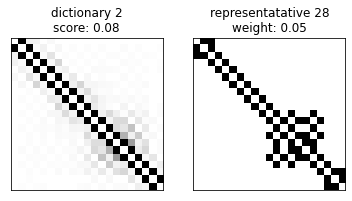

------- cluster 2, rep 28, pos in 0 -------
------- cluster 2, rep 1, pos in 1 -------


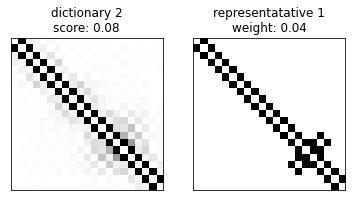

------- cluster 2, rep 1, pos in 1 -------
------- cluster 2, rep 4, pos in 2 -------


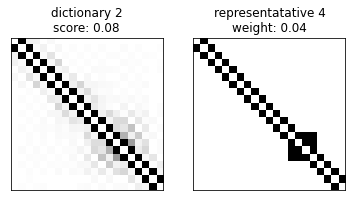

------- cluster 2, rep 4, pos in 2 -------
------- cluster 2, rep 8, pos in 3 -------


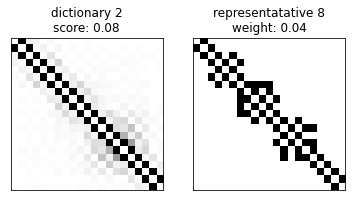

------- cluster 2, rep 8, pos in 3 -------
------- cluster 2, rep 23, pos in 4 -------


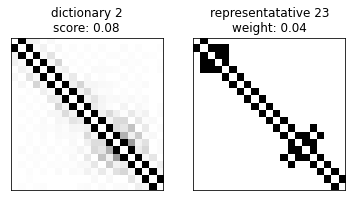

------- cluster 2, rep 23, pos in 4 -------
------- cluster 2, rep 30, pos in 5 -------


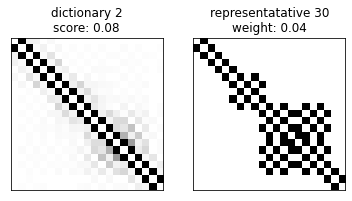

------- cluster 2, rep 30, pos in 5 -------
------- cluster 2, rep 24, pos in 6 -------


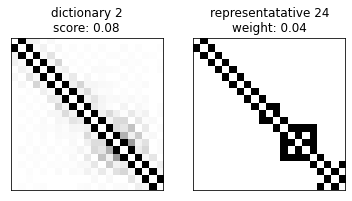

------- cluster 2, rep 24, pos in 6 -------
------- cluster 2, rep 10, pos in 7 -------


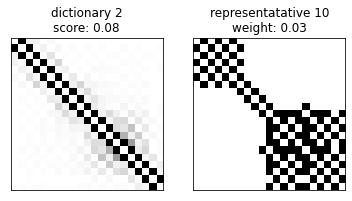

------- cluster 2, rep 10, pos in 7 -------
------- cluster 2, rep 20, pos in 8 -------


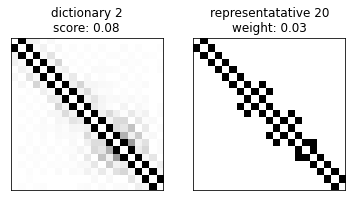

------- cluster 2, rep 20, pos in 8 -------
------- cluster 2, rep 17, pos in 9 -------


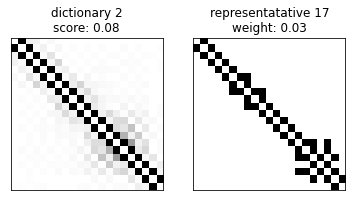

------- cluster 2, rep 17, pos in 9 -------
------- cluster 2, rep 14, pos in 10 -------


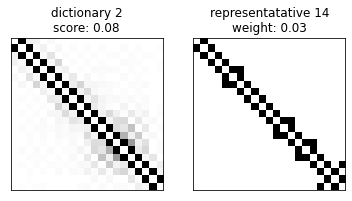

------- cluster 2, rep 14, pos in 10 -------
------- cluster 2, rep 0, pos in 11 -------


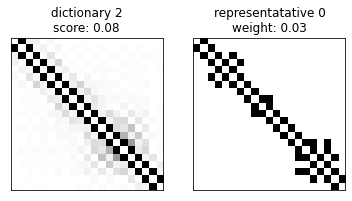

------- cluster 2, rep 0, pos in 11 -------
------- cluster 2, rep 13, pos in 12 -------


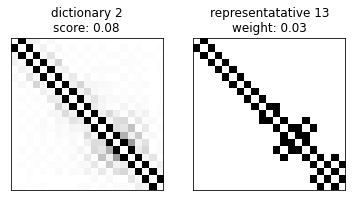

------- cluster 2, rep 13, pos in 12 -------
------- cluster 2, rep 32, pos in 13 -------


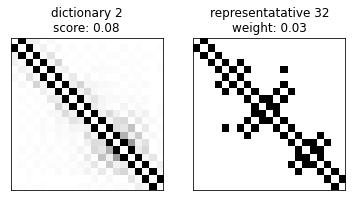

------- cluster 2, rep 32, pos in 13 -------
------- cluster 2, rep 22, pos in 14 -------


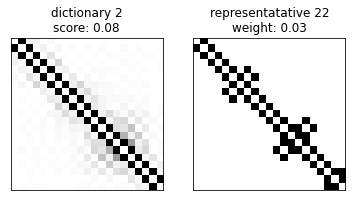

------- cluster 2, rep 22, pos in 14 -------
------- cluster 2, rep 31, pos in 15 -------


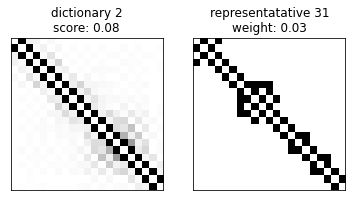

------- cluster 2, rep 31, pos in 15 -------
------- cluster 2, rep 6, pos in 16 -------


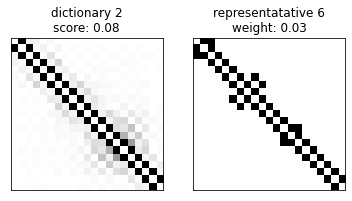

------- cluster 2, rep 6, pos in 16 -------
------- cluster 2, rep 2, pos in 17 -------


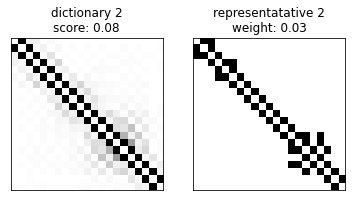

------- cluster 2, rep 2, pos in 17 -------
------- cluster 2, rep 3, pos in 18 -------


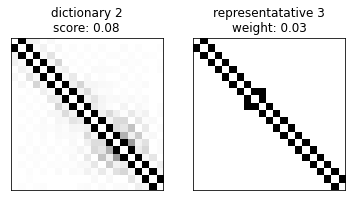

------- cluster 2, rep 3, pos in 18 -------
------- cluster 2, rep 19, pos in 19 -------


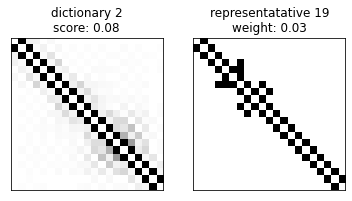

------- cluster 2, rep 19, pos in 19 -------
------- cluster 2, rep 7, pos in 20 -------


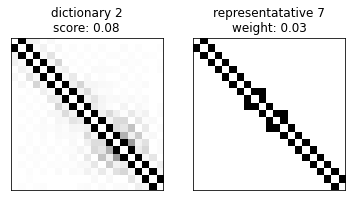

------- cluster 2, rep 7, pos in 20 -------
------- cluster 2, rep 15, pos in 21 -------


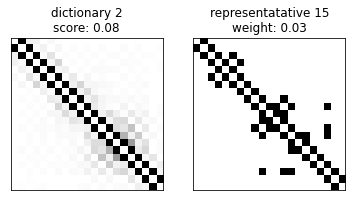

------- cluster 2, rep 15, pos in 21 -------
------- cluster 2, rep 26, pos in 22 -------


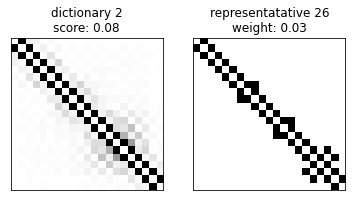

------- cluster 2, rep 26, pos in 22 -------
------- cluster 2, rep 21, pos in 23 -------


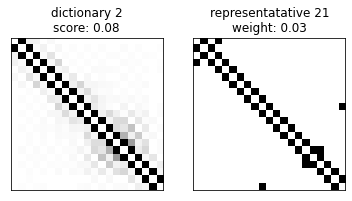

------- cluster 2, rep 21, pos in 23 -------
------- cluster 2, rep 5, pos in 24 -------


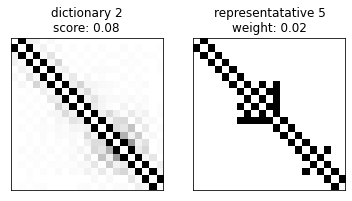

------- cluster 2, rep 5, pos in 24 -------
------- cluster 2, rep 25, pos in 25 -------


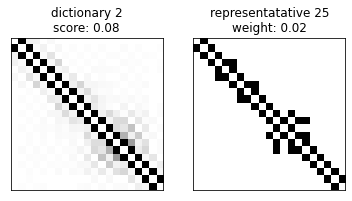

------- cluster 2, rep 25, pos in 25 -------
------- cluster 2, rep 11, pos in 26 -------


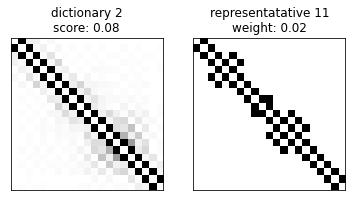

------- cluster 2, rep 11, pos in 26 -------
------- cluster 2, rep 35, pos in 27 -------


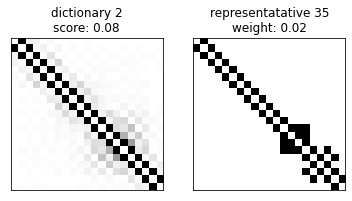

------- cluster 2, rep 35, pos in 27 -------
------- cluster 2, rep 18, pos in 28 -------


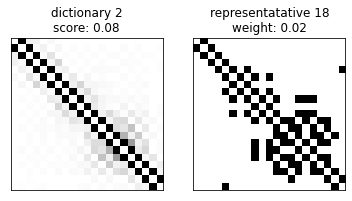

------- cluster 2, rep 18, pos in 28 -------
------- cluster 2, rep 16, pos in 29 -------


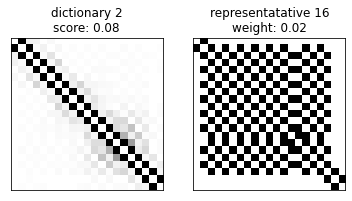

------- cluster 2, rep 16, pos in 29 -------
------- cluster 2, rep 29, pos in 30 -------


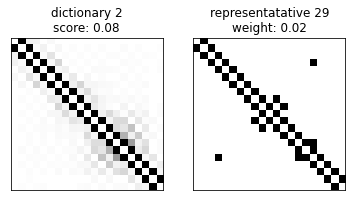

------- cluster 2, rep 29, pos in 30 -------
------- cluster 2, rep 34, pos in 31 -------


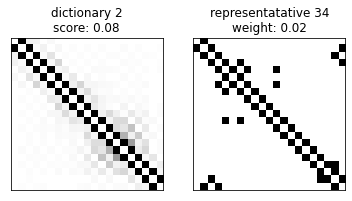

------- cluster 2, rep 34, pos in 31 -------
------- cluster 2, rep 33, pos in 32 -------


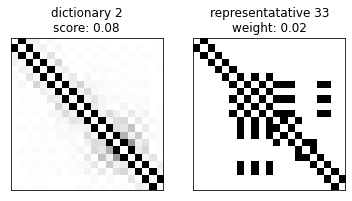

------- cluster 2, rep 33, pos in 32 -------
------- cluster 2, rep 12, pos in 33 -------


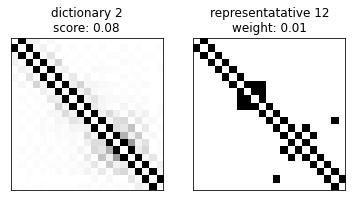

------- cluster 2, rep 12, pos in 33 -------
------- cluster 2, rep 9, pos in 34 -------


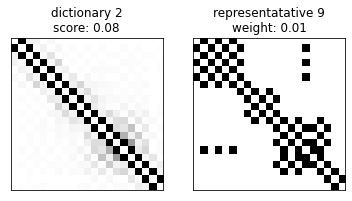

------- cluster 2, rep 9, pos in 34 -------
------- cluster 2, rep 27, pos in 35 -------


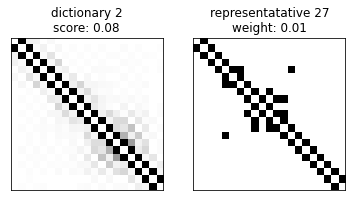

------- cluster 2, rep 27, pos in 35 -------
cluster : 0
------- cluster 0, rep 11, pos in 0 -------


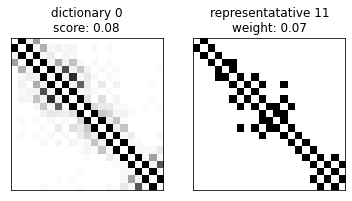

------- cluster 0, rep 11, pos in 0 -------
------- cluster 0, rep 10, pos in 1 -------


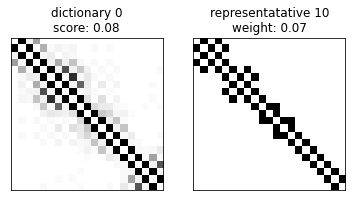

------- cluster 0, rep 10, pos in 1 -------
------- cluster 0, rep 17, pos in 2 -------


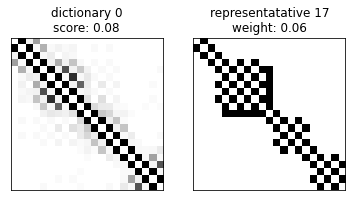

------- cluster 0, rep 17, pos in 2 -------
------- cluster 0, rep 16, pos in 3 -------


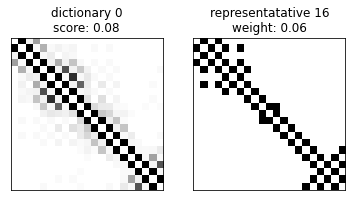

------- cluster 0, rep 16, pos in 3 -------
------- cluster 0, rep 14, pos in 4 -------


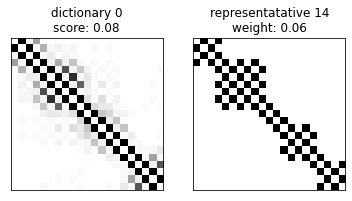

------- cluster 0, rep 14, pos in 4 -------
------- cluster 0, rep 6, pos in 5 -------


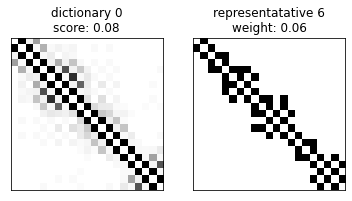

------- cluster 0, rep 6, pos in 5 -------
------- cluster 0, rep 3, pos in 6 -------


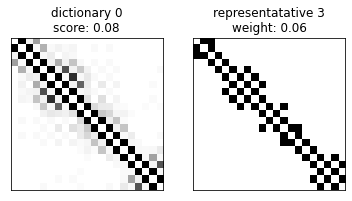

------- cluster 0, rep 3, pos in 6 -------
------- cluster 0, rep 0, pos in 7 -------


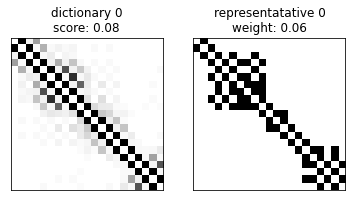

------- cluster 0, rep 0, pos in 7 -------
------- cluster 0, rep 4, pos in 8 -------


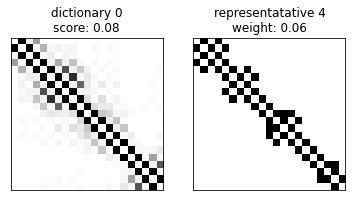

------- cluster 0, rep 4, pos in 8 -------
------- cluster 0, rep 15, pos in 9 -------


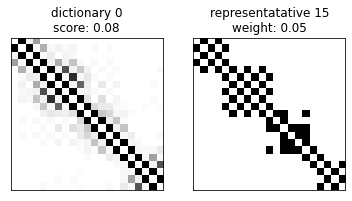

------- cluster 0, rep 15, pos in 9 -------
------- cluster 0, rep 12, pos in 10 -------


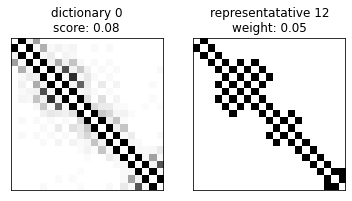

------- cluster 0, rep 12, pos in 10 -------
------- cluster 0, rep 7, pos in 11 -------


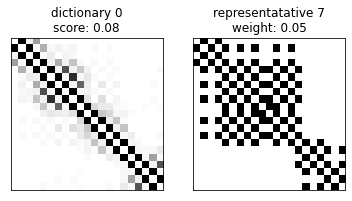

------- cluster 0, rep 7, pos in 11 -------
------- cluster 0, rep 8, pos in 12 -------


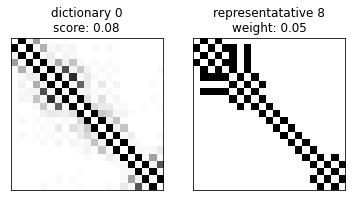

------- cluster 0, rep 8, pos in 12 -------
------- cluster 0, rep 1, pos in 13 -------


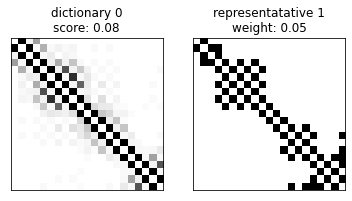

------- cluster 0, rep 1, pos in 13 -------
------- cluster 0, rep 13, pos in 14 -------


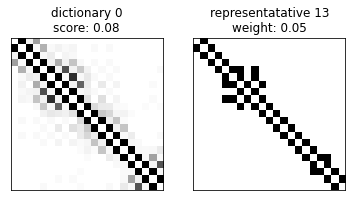

------- cluster 0, rep 13, pos in 14 -------
------- cluster 0, rep 5, pos in 15 -------


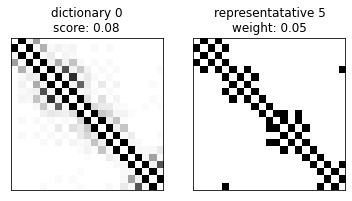

------- cluster 0, rep 5, pos in 15 -------
------- cluster 0, rep 9, pos in 16 -------


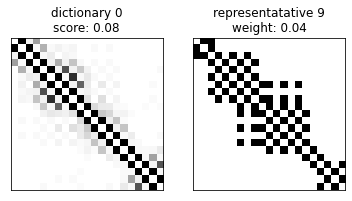

------- cluster 0, rep 9, pos in 16 -------
------- cluster 0, rep 18, pos in 17 -------


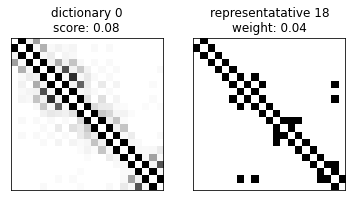

------- cluster 0, rep 18, pos in 17 -------
------- cluster 0, rep 2, pos in 18 -------


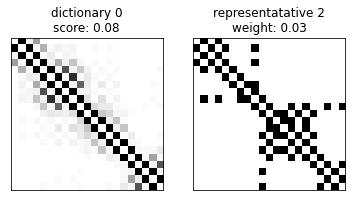

------- cluster 0, rep 2, pos in 18 -------
cluster : 5
------- cluster 5, rep 7, pos in 0 -------


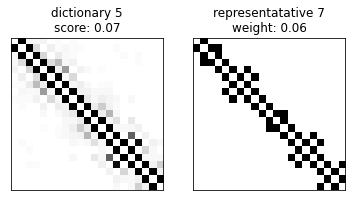

------- cluster 5, rep 7, pos in 0 -------
------- cluster 5, rep 12, pos in 1 -------


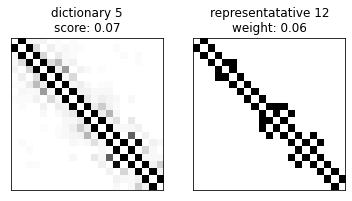

------- cluster 5, rep 12, pos in 1 -------
------- cluster 5, rep 18, pos in 2 -------


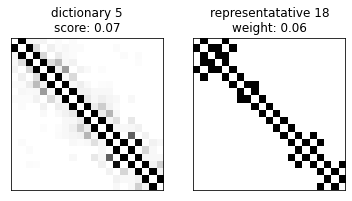

------- cluster 5, rep 18, pos in 2 -------
------- cluster 5, rep 14, pos in 3 -------


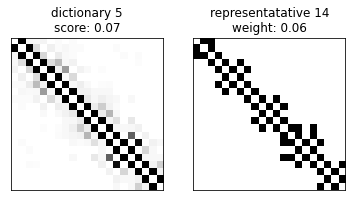

------- cluster 5, rep 14, pos in 3 -------
------- cluster 5, rep 13, pos in 4 -------


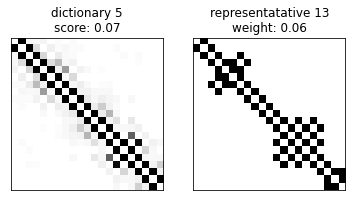

------- cluster 5, rep 13, pos in 4 -------
------- cluster 5, rep 10, pos in 5 -------


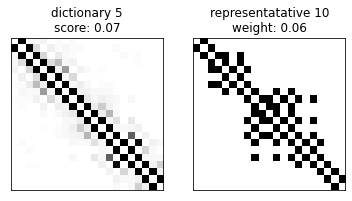

------- cluster 5, rep 10, pos in 5 -------
------- cluster 5, rep 3, pos in 6 -------


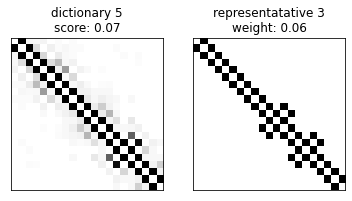

------- cluster 5, rep 3, pos in 6 -------
------- cluster 5, rep 4, pos in 7 -------


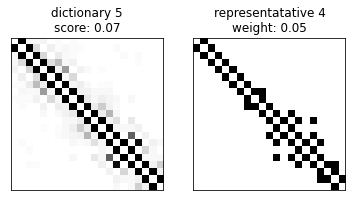

------- cluster 5, rep 4, pos in 7 -------
------- cluster 5, rep 19, pos in 8 -------


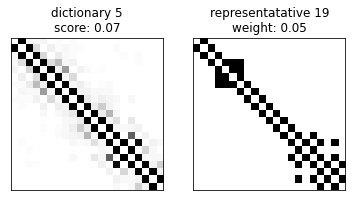

------- cluster 5, rep 19, pos in 8 -------
------- cluster 5, rep 15, pos in 9 -------


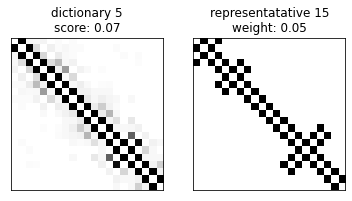

------- cluster 5, rep 15, pos in 9 -------
------- cluster 5, rep 16, pos in 10 -------


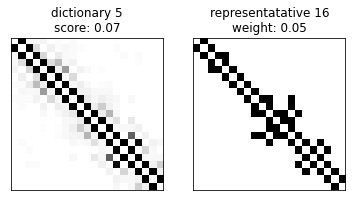

------- cluster 5, rep 16, pos in 10 -------
------- cluster 5, rep 6, pos in 11 -------


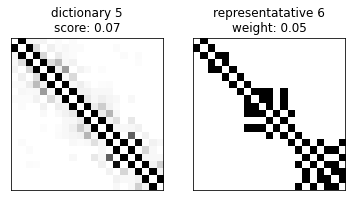

------- cluster 5, rep 6, pos in 11 -------
------- cluster 5, rep 2, pos in 12 -------


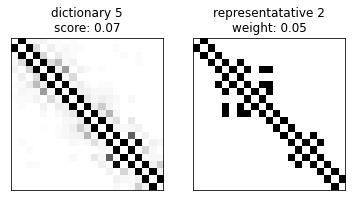

------- cluster 5, rep 2, pos in 12 -------
------- cluster 5, rep 8, pos in 13 -------


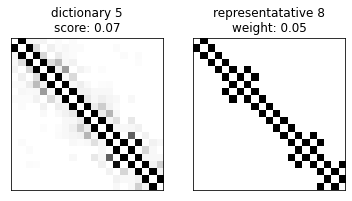

------- cluster 5, rep 8, pos in 13 -------
------- cluster 5, rep 9, pos in 14 -------


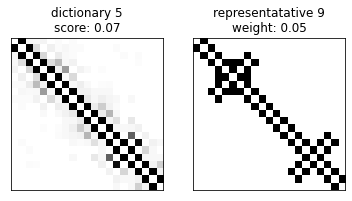

------- cluster 5, rep 9, pos in 14 -------
------- cluster 5, rep 0, pos in 15 -------


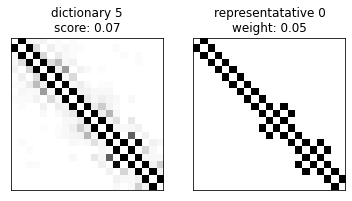

------- cluster 5, rep 0, pos in 15 -------
------- cluster 5, rep 5, pos in 16 -------


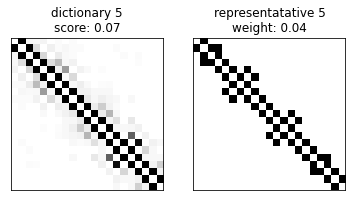

------- cluster 5, rep 5, pos in 16 -------
------- cluster 5, rep 17, pos in 17 -------


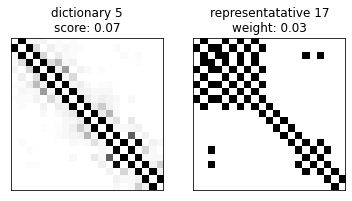

------- cluster 5, rep 17, pos in 17 -------
------- cluster 5, rep 1, pos in 18 -------


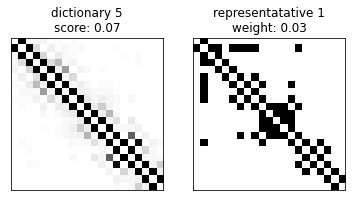

------- cluster 5, rep 1, pos in 18 -------
------- cluster 5, rep 11, pos in 19 -------


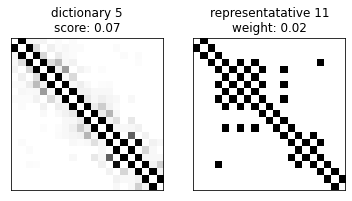

------- cluster 5, rep 11, pos in 19 -------
cluster : 21
------- cluster 21, rep 17, pos in 0 -------


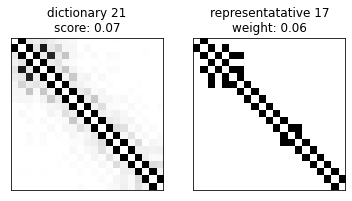

------- cluster 21, rep 17, pos in 0 -------
------- cluster 21, rep 7, pos in 1 -------


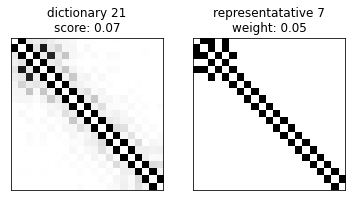

------- cluster 21, rep 7, pos in 1 -------
------- cluster 21, rep 1, pos in 2 -------


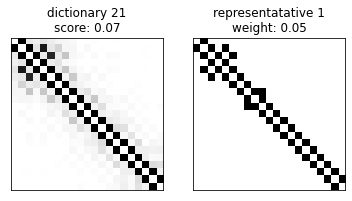

------- cluster 21, rep 1, pos in 2 -------
------- cluster 21, rep 15, pos in 3 -------


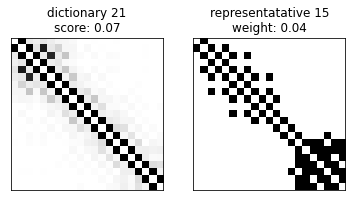

------- cluster 21, rep 15, pos in 3 -------
------- cluster 21, rep 10, pos in 4 -------


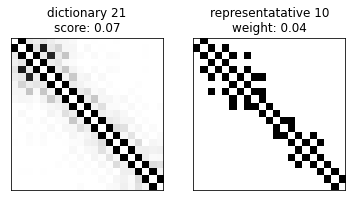

------- cluster 21, rep 10, pos in 4 -------
------- cluster 21, rep 26, pos in 5 -------


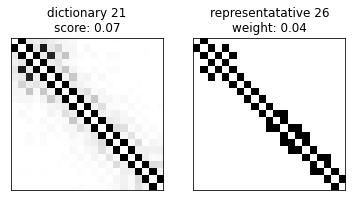

------- cluster 21, rep 26, pos in 5 -------
------- cluster 21, rep 9, pos in 6 -------


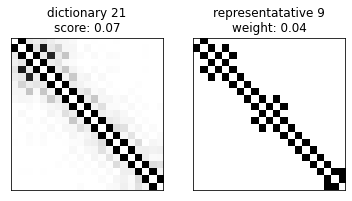

------- cluster 21, rep 9, pos in 6 -------
------- cluster 21, rep 11, pos in 7 -------


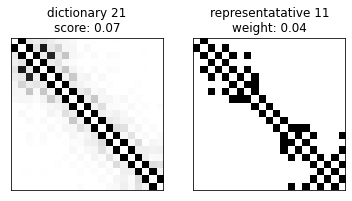

------- cluster 21, rep 11, pos in 7 -------
------- cluster 21, rep 31, pos in 8 -------


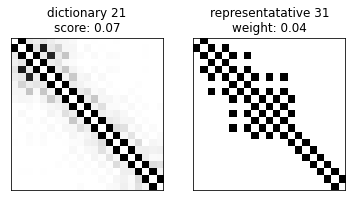

------- cluster 21, rep 31, pos in 8 -------
------- cluster 21, rep 28, pos in 9 -------


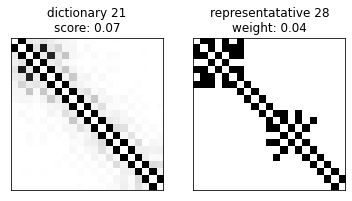

------- cluster 21, rep 28, pos in 9 -------
------- cluster 21, rep 14, pos in 10 -------


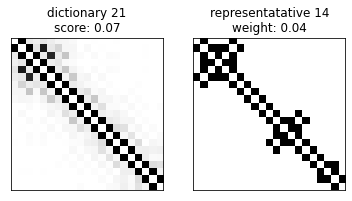

------- cluster 21, rep 14, pos in 10 -------
------- cluster 21, rep 20, pos in 11 -------


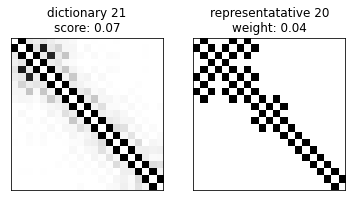

------- cluster 21, rep 20, pos in 11 -------
------- cluster 21, rep 0, pos in 12 -------


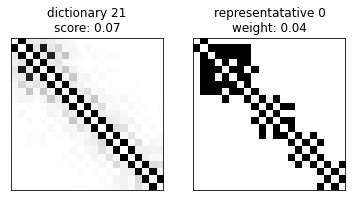

------- cluster 21, rep 0, pos in 12 -------
------- cluster 21, rep 18, pos in 13 -------


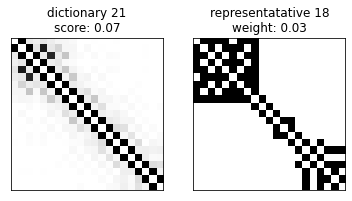

------- cluster 21, rep 18, pos in 13 -------
------- cluster 21, rep 16, pos in 14 -------


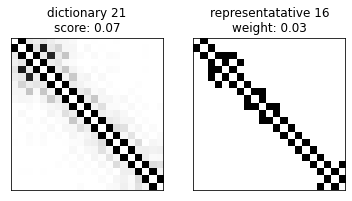

------- cluster 21, rep 16, pos in 14 -------
------- cluster 21, rep 5, pos in 15 -------


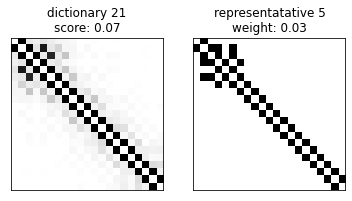

------- cluster 21, rep 5, pos in 15 -------
------- cluster 21, rep 12, pos in 16 -------


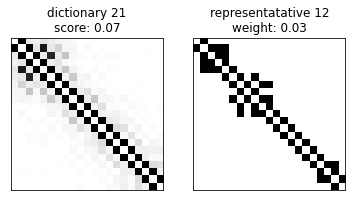

------- cluster 21, rep 12, pos in 16 -------
------- cluster 21, rep 4, pos in 17 -------


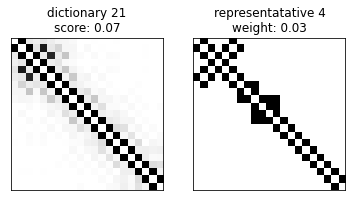

------- cluster 21, rep 4, pos in 17 -------
------- cluster 21, rep 25, pos in 18 -------


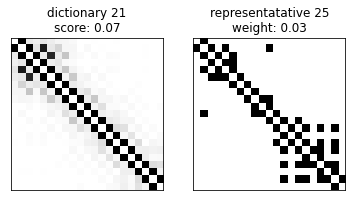

------- cluster 21, rep 25, pos in 18 -------
------- cluster 21, rep 2, pos in 19 -------


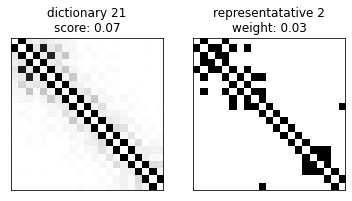

------- cluster 21, rep 2, pos in 19 -------
------- cluster 21, rep 3, pos in 20 -------


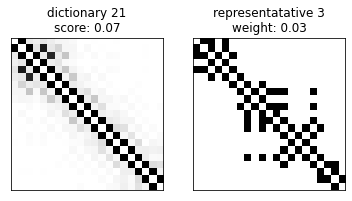

------- cluster 21, rep 3, pos in 20 -------
------- cluster 21, rep 8, pos in 21 -------


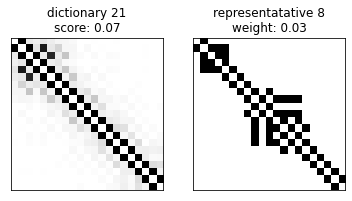

------- cluster 21, rep 8, pos in 21 -------
------- cluster 21, rep 22, pos in 22 -------


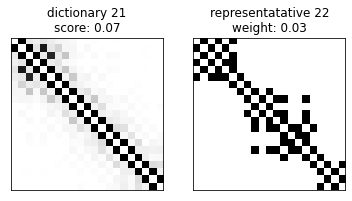

------- cluster 21, rep 22, pos in 22 -------
------- cluster 21, rep 29, pos in 23 -------


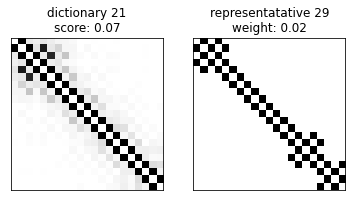

------- cluster 21, rep 29, pos in 23 -------
------- cluster 21, rep 19, pos in 24 -------


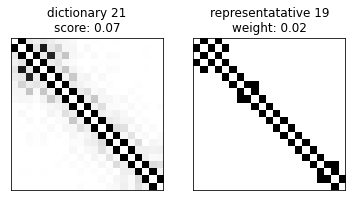

------- cluster 21, rep 19, pos in 24 -------
------- cluster 21, rep 23, pos in 25 -------


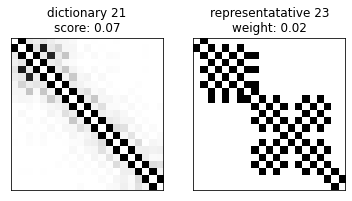

------- cluster 21, rep 23, pos in 25 -------
------- cluster 21, rep 6, pos in 26 -------


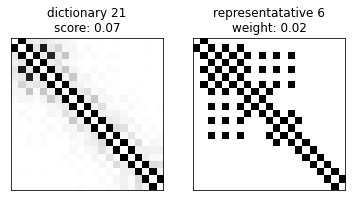

------- cluster 21, rep 6, pos in 26 -------
------- cluster 21, rep 21, pos in 27 -------


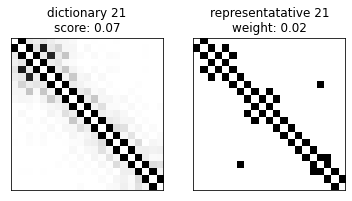

------- cluster 21, rep 21, pos in 27 -------
------- cluster 21, rep 30, pos in 28 -------


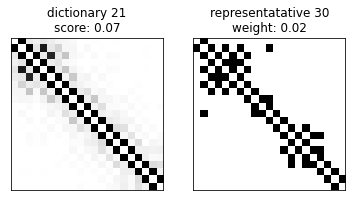

------- cluster 21, rep 30, pos in 28 -------
------- cluster 21, rep 24, pos in 29 -------


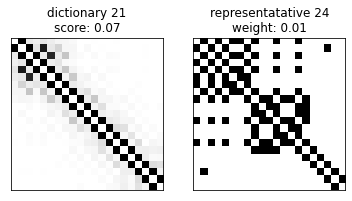

------- cluster 21, rep 24, pos in 29 -------
------- cluster 21, rep 13, pos in 30 -------


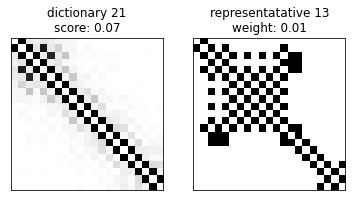

------- cluster 21, rep 13, pos in 30 -------
------- cluster 21, rep 27, pos in 31 -------


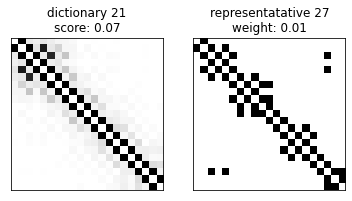

------- cluster 21, rep 27, pos in 31 -------
cluster : 7
------- cluster 7, rep 17, pos in 0 -------


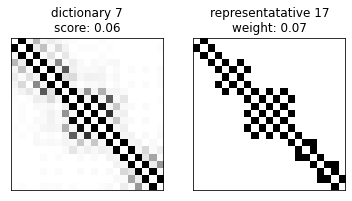

------- cluster 7, rep 17, pos in 0 -------
------- cluster 7, rep 19, pos in 1 -------


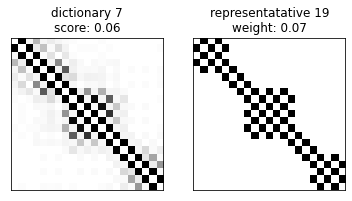

------- cluster 7, rep 19, pos in 1 -------
------- cluster 7, rep 10, pos in 2 -------


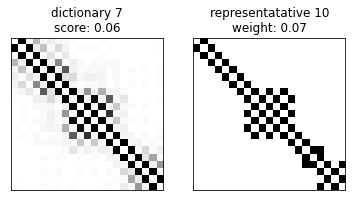

------- cluster 7, rep 10, pos in 2 -------
------- cluster 7, rep 5, pos in 3 -------


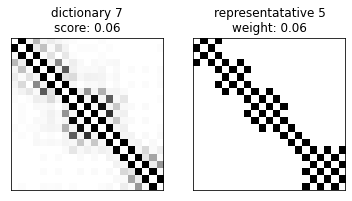

------- cluster 7, rep 5, pos in 3 -------
------- cluster 7, rep 16, pos in 4 -------


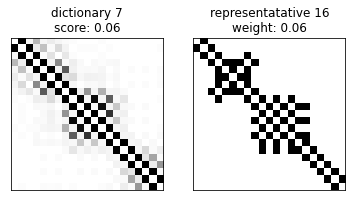

------- cluster 7, rep 16, pos in 4 -------
------- cluster 7, rep 3, pos in 5 -------


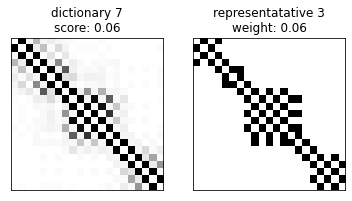

------- cluster 7, rep 3, pos in 5 -------
------- cluster 7, rep 7, pos in 6 -------


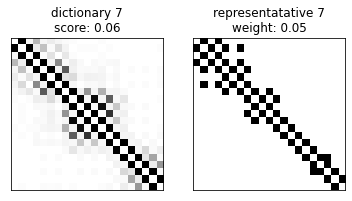

------- cluster 7, rep 7, pos in 6 -------
------- cluster 7, rep 0, pos in 7 -------


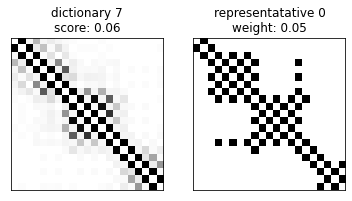

------- cluster 7, rep 0, pos in 7 -------
------- cluster 7, rep 6, pos in 8 -------


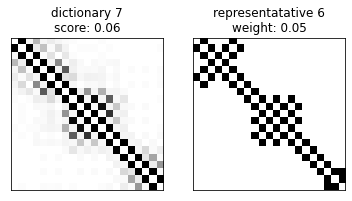

------- cluster 7, rep 6, pos in 8 -------
------- cluster 7, rep 4, pos in 9 -------


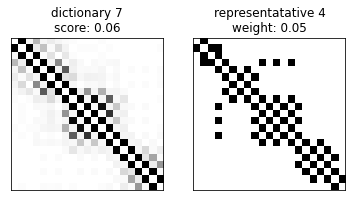

------- cluster 7, rep 4, pos in 9 -------
------- cluster 7, rep 9, pos in 10 -------


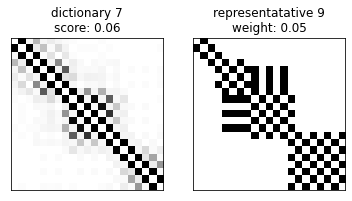

------- cluster 7, rep 9, pos in 10 -------
------- cluster 7, rep 18, pos in 11 -------


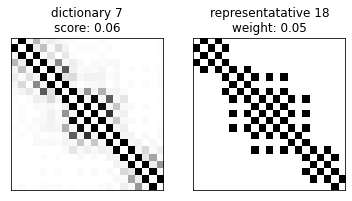

------- cluster 7, rep 18, pos in 11 -------
------- cluster 7, rep 15, pos in 12 -------


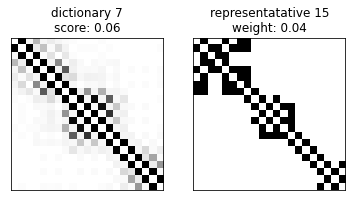

------- cluster 7, rep 15, pos in 12 -------
------- cluster 7, rep 13, pos in 13 -------


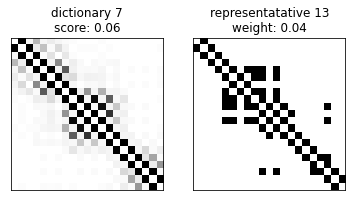

------- cluster 7, rep 13, pos in 13 -------
------- cluster 7, rep 2, pos in 14 -------


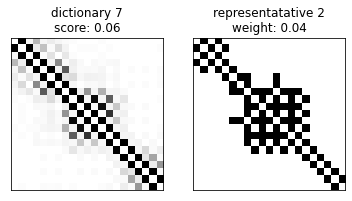

------- cluster 7, rep 2, pos in 14 -------
------- cluster 7, rep 8, pos in 15 -------


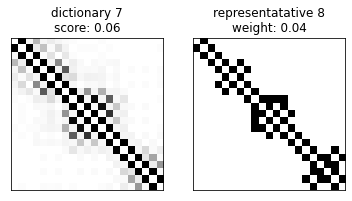

------- cluster 7, rep 8, pos in 15 -------
------- cluster 7, rep 20, pos in 16 -------


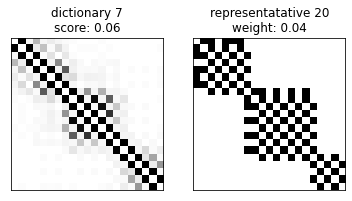

------- cluster 7, rep 20, pos in 16 -------
------- cluster 7, rep 1, pos in 17 -------


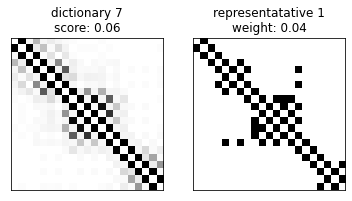

------- cluster 7, rep 1, pos in 17 -------
------- cluster 7, rep 11, pos in 18 -------


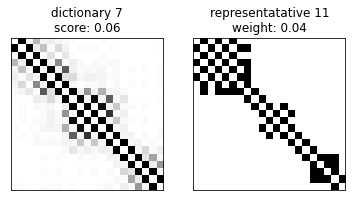

------- cluster 7, rep 11, pos in 18 -------
------- cluster 7, rep 14, pos in 19 -------


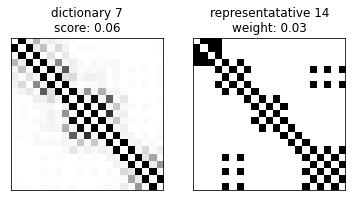

------- cluster 7, rep 14, pos in 19 -------
------- cluster 7, rep 12, pos in 20 -------


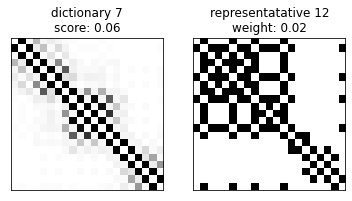

------- cluster 7, rep 12, pos in 20 -------
cluster : 4
------- cluster 4, rep 6, pos in 0 -------


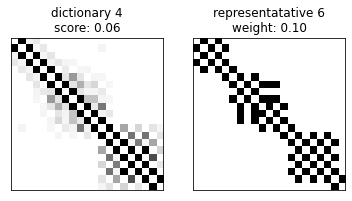

------- cluster 4, rep 6, pos in 0 -------
------- cluster 4, rep 9, pos in 1 -------


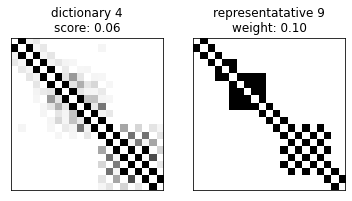

------- cluster 4, rep 9, pos in 1 -------
------- cluster 4, rep 10, pos in 2 -------


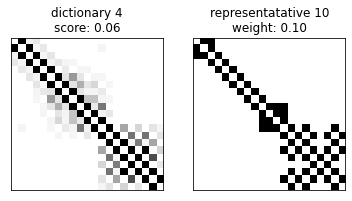

------- cluster 4, rep 10, pos in 2 -------
------- cluster 4, rep 3, pos in 3 -------


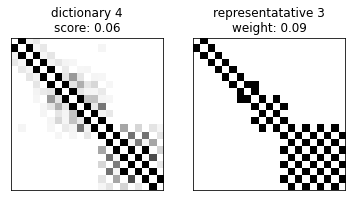

------- cluster 4, rep 3, pos in 3 -------
------- cluster 4, rep 0, pos in 4 -------


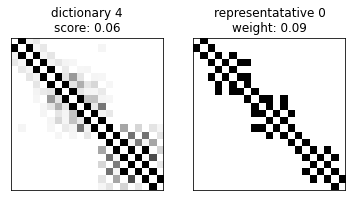

------- cluster 4, rep 0, pos in 4 -------
------- cluster 4, rep 1, pos in 5 -------


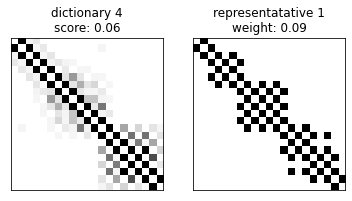

------- cluster 4, rep 1, pos in 5 -------
------- cluster 4, rep 2, pos in 6 -------


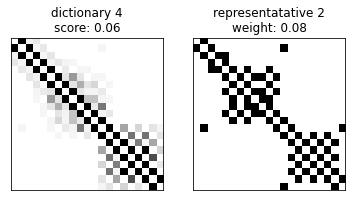

------- cluster 4, rep 2, pos in 6 -------
------- cluster 4, rep 8, pos in 7 -------


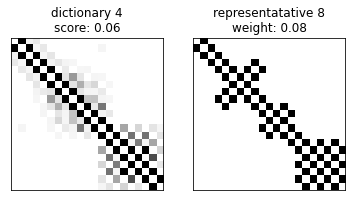

------- cluster 4, rep 8, pos in 7 -------
------- cluster 4, rep 7, pos in 8 -------


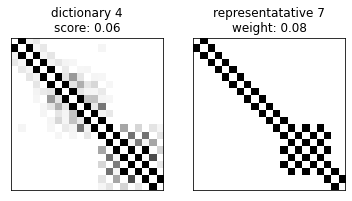

------- cluster 4, rep 7, pos in 8 -------
------- cluster 4, rep 4, pos in 9 -------


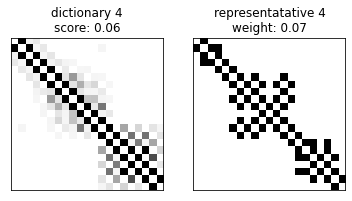

------- cluster 4, rep 4, pos in 9 -------
------- cluster 4, rep 11, pos in 10 -------


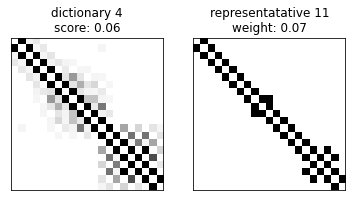

------- cluster 4, rep 11, pos in 10 -------
------- cluster 4, rep 5, pos in 11 -------


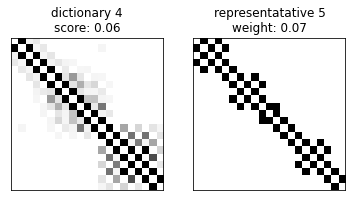

------- cluster 4, rep 5, pos in 11 -------
cluster : 8
------- cluster 8, rep 9, pos in 0 -------


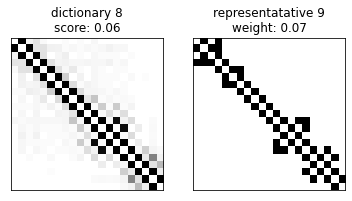

------- cluster 8, rep 9, pos in 0 -------
------- cluster 8, rep 21, pos in 1 -------


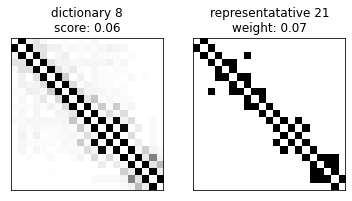

------- cluster 8, rep 21, pos in 1 -------
------- cluster 8, rep 6, pos in 2 -------


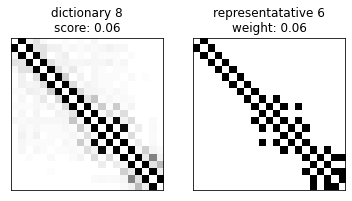

------- cluster 8, rep 6, pos in 2 -------
------- cluster 8, rep 0, pos in 3 -------


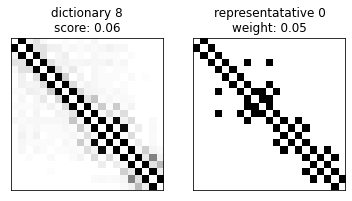

------- cluster 8, rep 0, pos in 3 -------
------- cluster 8, rep 8, pos in 4 -------


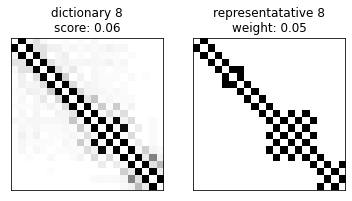

------- cluster 8, rep 8, pos in 4 -------
------- cluster 8, rep 13, pos in 5 -------


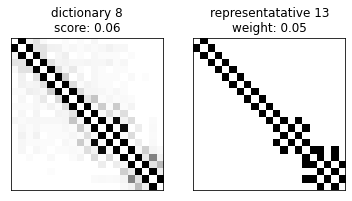

------- cluster 8, rep 13, pos in 5 -------
------- cluster 8, rep 16, pos in 6 -------


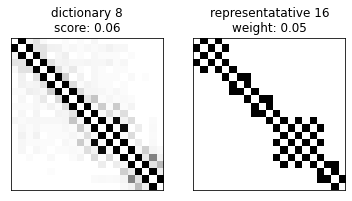

------- cluster 8, rep 16, pos in 6 -------
------- cluster 8, rep 11, pos in 7 -------


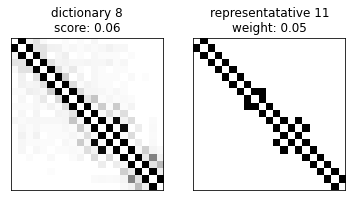

------- cluster 8, rep 11, pos in 7 -------
------- cluster 8, rep 12, pos in 8 -------


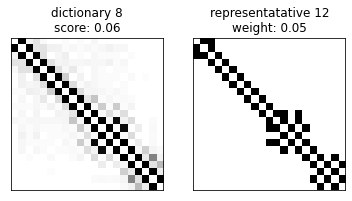

------- cluster 8, rep 12, pos in 8 -------
------- cluster 8, rep 3, pos in 9 -------


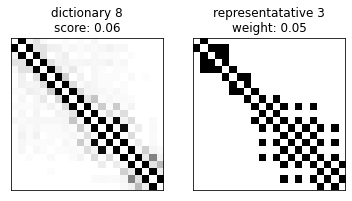

------- cluster 8, rep 3, pos in 9 -------
------- cluster 8, rep 14, pos in 10 -------


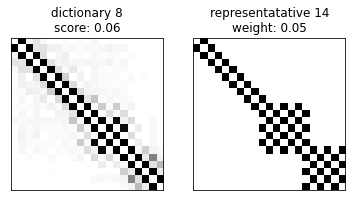

------- cluster 8, rep 14, pos in 10 -------
------- cluster 8, rep 17, pos in 11 -------


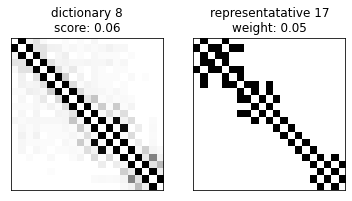

------- cluster 8, rep 17, pos in 11 -------
------- cluster 8, rep 7, pos in 12 -------


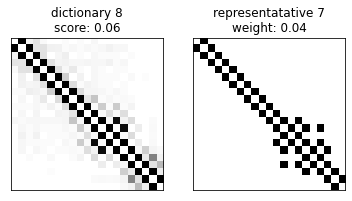

------- cluster 8, rep 7, pos in 12 -------
------- cluster 8, rep 1, pos in 13 -------


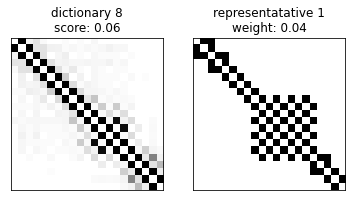

------- cluster 8, rep 1, pos in 13 -------
------- cluster 8, rep 10, pos in 14 -------


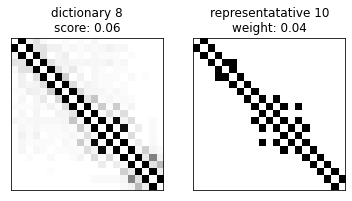

------- cluster 8, rep 10, pos in 14 -------
------- cluster 8, rep 4, pos in 15 -------


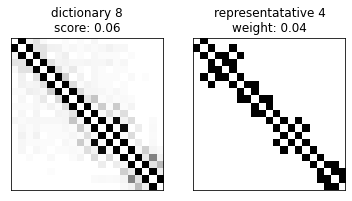

------- cluster 8, rep 4, pos in 15 -------
------- cluster 8, rep 15, pos in 16 -------


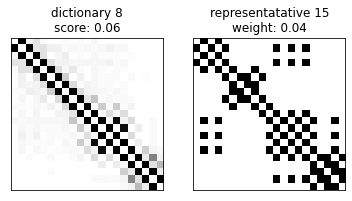

------- cluster 8, rep 15, pos in 16 -------
------- cluster 8, rep 18, pos in 17 -------


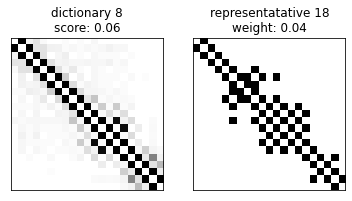

------- cluster 8, rep 18, pos in 17 -------
------- cluster 8, rep 19, pos in 18 -------


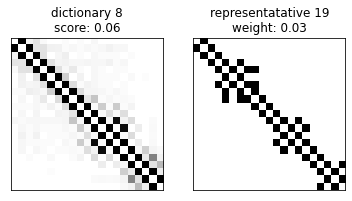

------- cluster 8, rep 19, pos in 18 -------
------- cluster 8, rep 2, pos in 19 -------


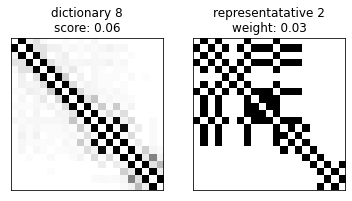

------- cluster 8, rep 2, pos in 19 -------
------- cluster 8, rep 5, pos in 20 -------


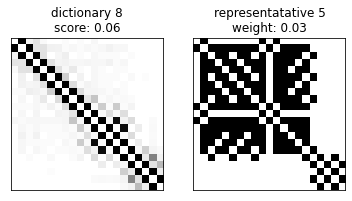

------- cluster 8, rep 5, pos in 20 -------
------- cluster 8, rep 20, pos in 21 -------


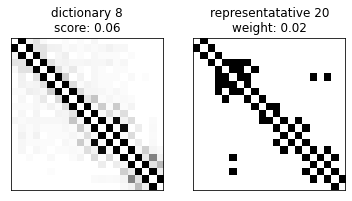

------- cluster 8, rep 20, pos in 21 -------
cluster : 14
------- cluster 14, rep 6, pos in 0 -------


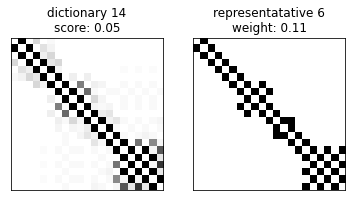

------- cluster 14, rep 6, pos in 0 -------
------- cluster 14, rep 10, pos in 1 -------


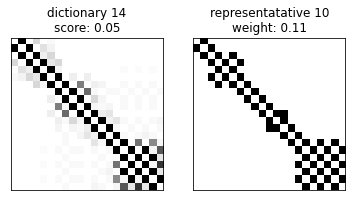

------- cluster 14, rep 10, pos in 1 -------
------- cluster 14, rep 5, pos in 2 -------


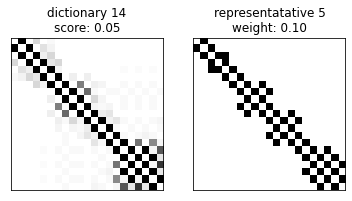

------- cluster 14, rep 5, pos in 2 -------
------- cluster 14, rep 3, pos in 3 -------


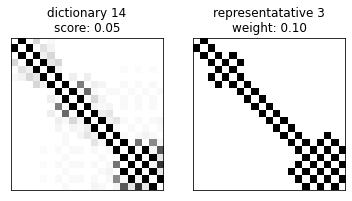

------- cluster 14, rep 3, pos in 3 -------
------- cluster 14, rep 7, pos in 4 -------


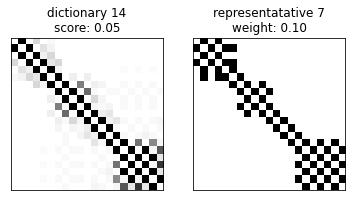

------- cluster 14, rep 7, pos in 4 -------
------- cluster 14, rep 9, pos in 5 -------


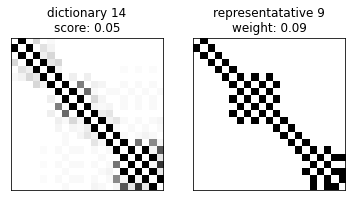

------- cluster 14, rep 9, pos in 5 -------
------- cluster 14, rep 4, pos in 6 -------


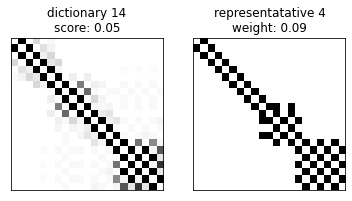

------- cluster 14, rep 4, pos in 6 -------
------- cluster 14, rep 2, pos in 7 -------


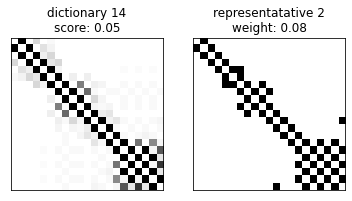

------- cluster 14, rep 2, pos in 7 -------
------- cluster 14, rep 8, pos in 8 -------


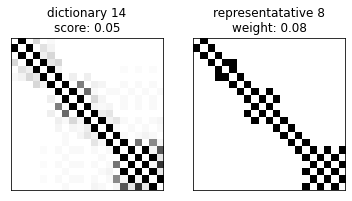

------- cluster 14, rep 8, pos in 8 -------
------- cluster 14, rep 0, pos in 9 -------


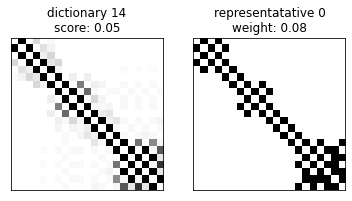

------- cluster 14, rep 0, pos in 9 -------
------- cluster 14, rep 1, pos in 10 -------


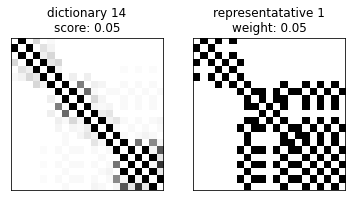

------- cluster 14, rep 1, pos in 10 -------
------- cluster 14, rep 11, pos in 11 -------


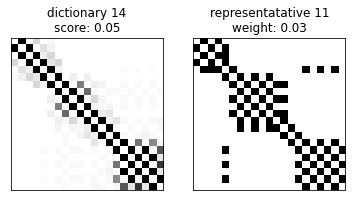

------- cluster 14, rep 11, pos in 11 -------
cluster : 22
------- cluster 22, rep 2, pos in 0 -------


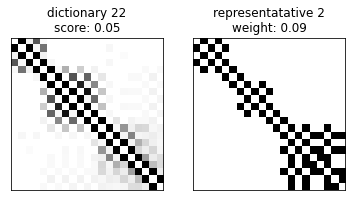

------- cluster 22, rep 2, pos in 0 -------
------- cluster 22, rep 5, pos in 1 -------


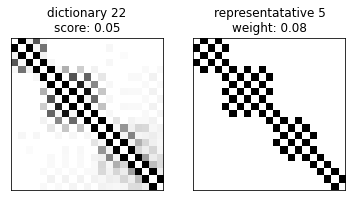

------- cluster 22, rep 5, pos in 1 -------
------- cluster 22, rep 8, pos in 2 -------


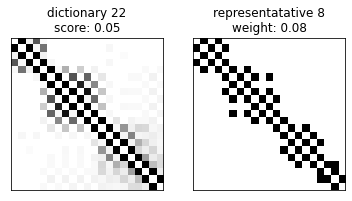

------- cluster 22, rep 8, pos in 2 -------
------- cluster 22, rep 16, pos in 3 -------


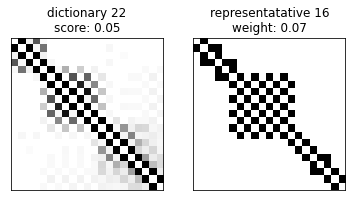

------- cluster 22, rep 16, pos in 3 -------
------- cluster 22, rep 7, pos in 4 -------


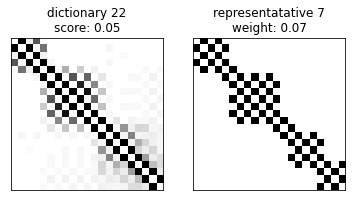

------- cluster 22, rep 7, pos in 4 -------
------- cluster 22, rep 12, pos in 5 -------


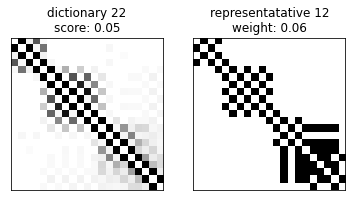

------- cluster 22, rep 12, pos in 5 -------
------- cluster 22, rep 9, pos in 6 -------


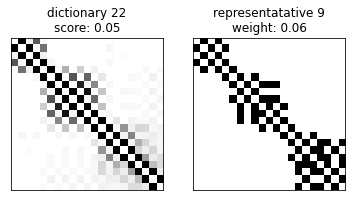

------- cluster 22, rep 9, pos in 6 -------
------- cluster 22, rep 15, pos in 7 -------


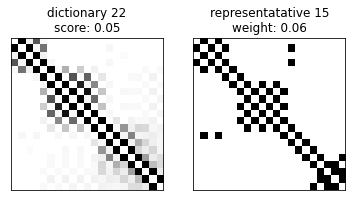

------- cluster 22, rep 15, pos in 7 -------
------- cluster 22, rep 1, pos in 8 -------


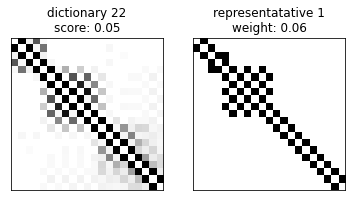

------- cluster 22, rep 1, pos in 8 -------
------- cluster 22, rep 0, pos in 9 -------


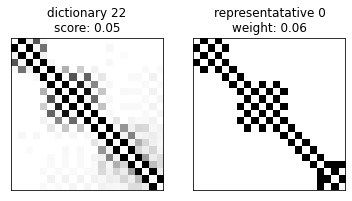

------- cluster 22, rep 0, pos in 9 -------
------- cluster 22, rep 13, pos in 10 -------


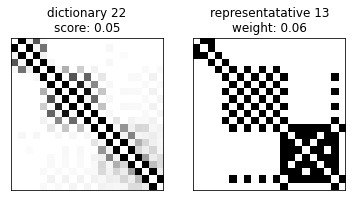

------- cluster 22, rep 13, pos in 10 -------
------- cluster 22, rep 14, pos in 11 -------


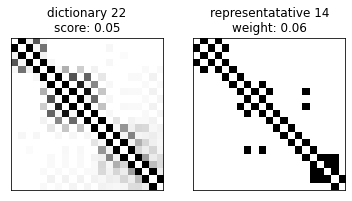

------- cluster 22, rep 14, pos in 11 -------
------- cluster 22, rep 4, pos in 12 -------


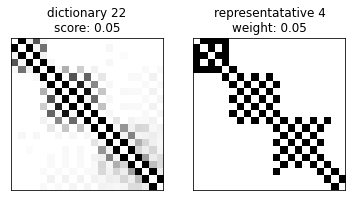

------- cluster 22, rep 4, pos in 12 -------
------- cluster 22, rep 6, pos in 13 -------


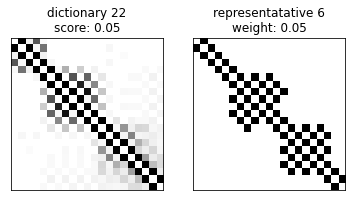

------- cluster 22, rep 6, pos in 13 -------
------- cluster 22, rep 3, pos in 14 -------


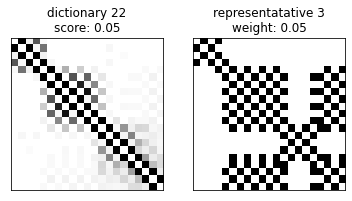

------- cluster 22, rep 3, pos in 14 -------
------- cluster 22, rep 10, pos in 15 -------


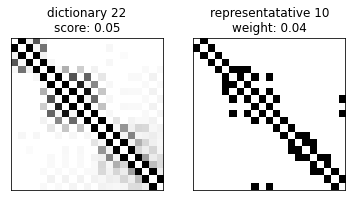

------- cluster 22, rep 10, pos in 15 -------
------- cluster 22, rep 11, pos in 16 -------


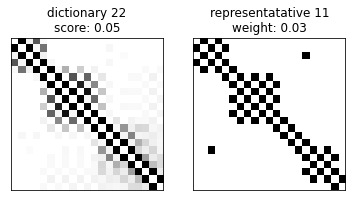

------- cluster 22, rep 11, pos in 16 -------
cluster : 17
------- cluster 17, rep 2, pos in 0 -------


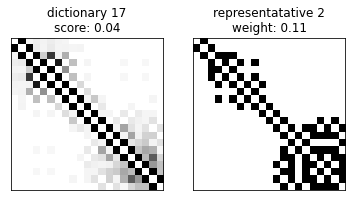

------- cluster 17, rep 2, pos in 0 -------
------- cluster 17, rep 0, pos in 1 -------


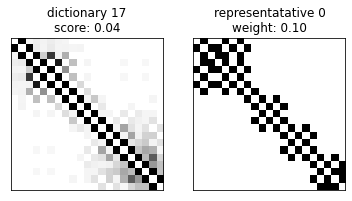

------- cluster 17, rep 0, pos in 1 -------
------- cluster 17, rep 5, pos in 2 -------


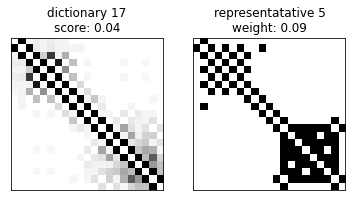

------- cluster 17, rep 5, pos in 2 -------
------- cluster 17, rep 9, pos in 3 -------


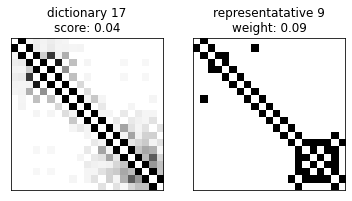

------- cluster 17, rep 9, pos in 3 -------
------- cluster 17, rep 7, pos in 4 -------


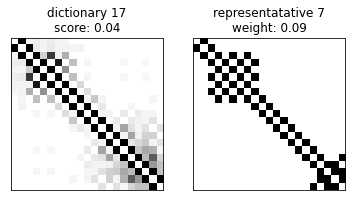

------- cluster 17, rep 7, pos in 4 -------
------- cluster 17, rep 1, pos in 5 -------


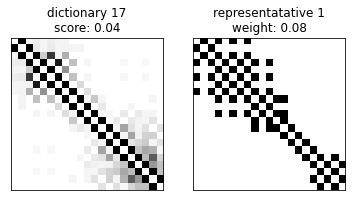

------- cluster 17, rep 1, pos in 5 -------
------- cluster 17, rep 8, pos in 6 -------


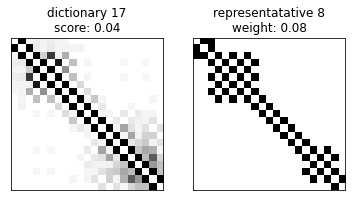

------- cluster 17, rep 8, pos in 6 -------
------- cluster 17, rep 3, pos in 7 -------


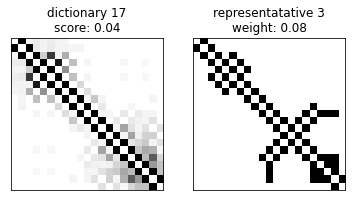

------- cluster 17, rep 3, pos in 7 -------
------- cluster 17, rep 10, pos in 8 -------


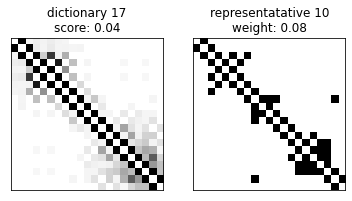

------- cluster 17, rep 10, pos in 8 -------
------- cluster 17, rep 11, pos in 9 -------


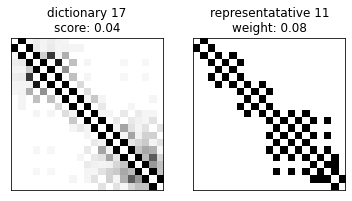

------- cluster 17, rep 11, pos in 9 -------
------- cluster 17, rep 6, pos in 10 -------


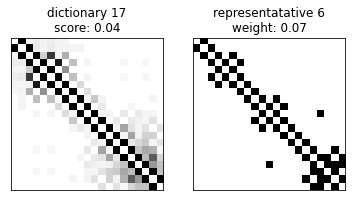

------- cluster 17, rep 6, pos in 10 -------
------- cluster 17, rep 4, pos in 11 -------


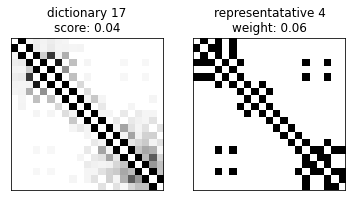

------- cluster 17, rep 4, pos in 11 -------
cluster : 6
------- cluster 6, rep 13, pos in 0 -------


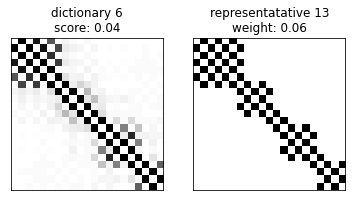

------- cluster 6, rep 13, pos in 0 -------
------- cluster 6, rep 18, pos in 1 -------


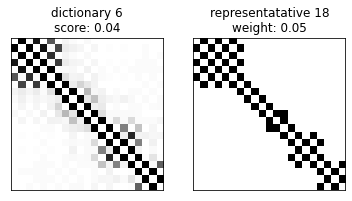

------- cluster 6, rep 18, pos in 1 -------
------- cluster 6, rep 17, pos in 2 -------


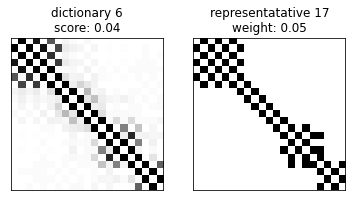

------- cluster 6, rep 17, pos in 2 -------
------- cluster 6, rep 1, pos in 3 -------


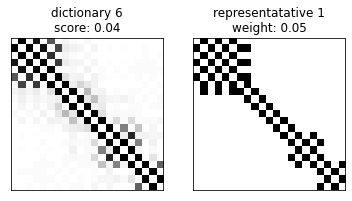

------- cluster 6, rep 1, pos in 3 -------
------- cluster 6, rep 23, pos in 4 -------


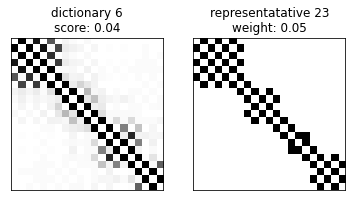

------- cluster 6, rep 23, pos in 4 -------
------- cluster 6, rep 12, pos in 5 -------


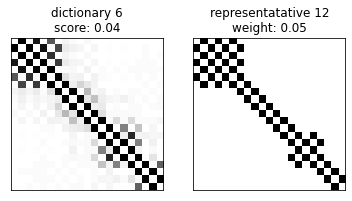

------- cluster 6, rep 12, pos in 5 -------
------- cluster 6, rep 7, pos in 6 -------


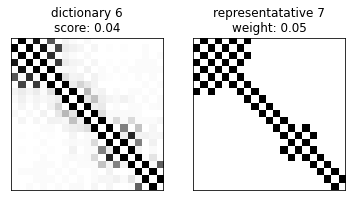

------- cluster 6, rep 7, pos in 6 -------
------- cluster 6, rep 11, pos in 7 -------


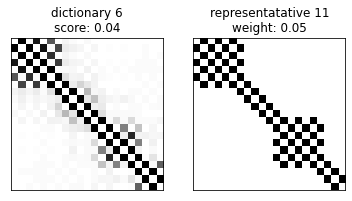

------- cluster 6, rep 11, pos in 7 -------
------- cluster 6, rep 20, pos in 8 -------


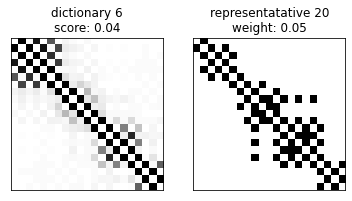

------- cluster 6, rep 20, pos in 8 -------
------- cluster 6, rep 3, pos in 9 -------


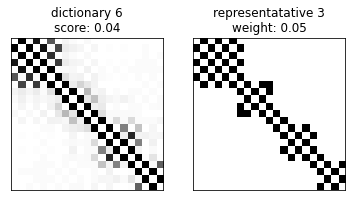

------- cluster 6, rep 3, pos in 9 -------
------- cluster 6, rep 8, pos in 10 -------


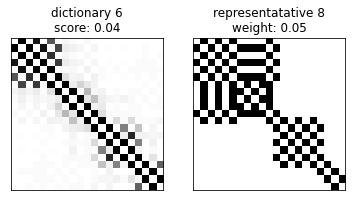

------- cluster 6, rep 8, pos in 10 -------
------- cluster 6, rep 4, pos in 11 -------


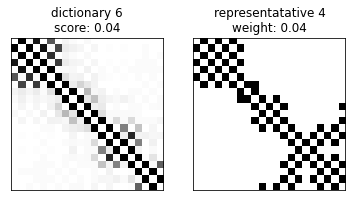

------- cluster 6, rep 4, pos in 11 -------
------- cluster 6, rep 10, pos in 12 -------


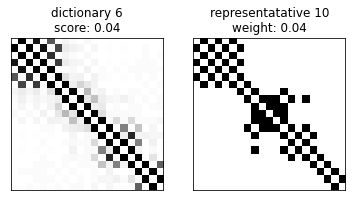

------- cluster 6, rep 10, pos in 12 -------
------- cluster 6, rep 15, pos in 13 -------


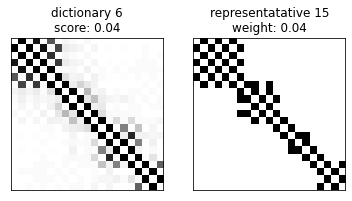

------- cluster 6, rep 15, pos in 13 -------
------- cluster 6, rep 21, pos in 14 -------


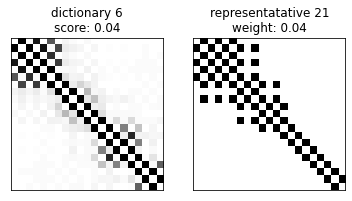

------- cluster 6, rep 21, pos in 14 -------
------- cluster 6, rep 6, pos in 15 -------


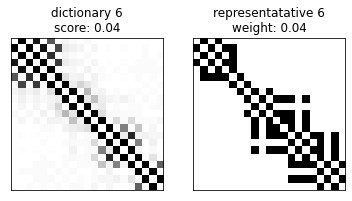

------- cluster 6, rep 6, pos in 15 -------
------- cluster 6, rep 2, pos in 16 -------


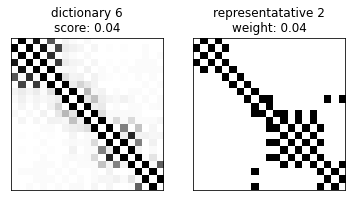

------- cluster 6, rep 2, pos in 16 -------
------- cluster 6, rep 16, pos in 17 -------


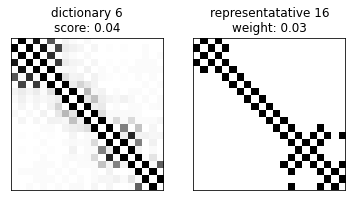

------- cluster 6, rep 16, pos in 17 -------
------- cluster 6, rep 22, pos in 18 -------


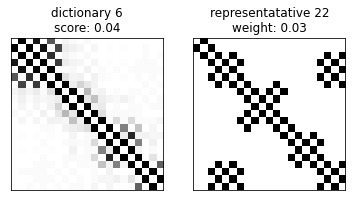

------- cluster 6, rep 22, pos in 18 -------
------- cluster 6, rep 0, pos in 19 -------


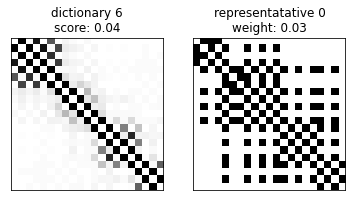

------- cluster 6, rep 0, pos in 19 -------
------- cluster 6, rep 14, pos in 20 -------


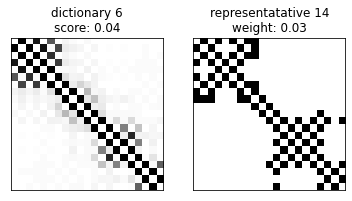

------- cluster 6, rep 14, pos in 20 -------
------- cluster 6, rep 9, pos in 21 -------


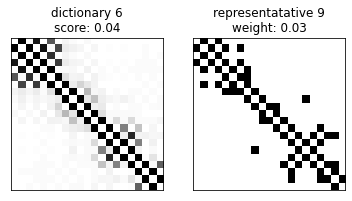

------- cluster 6, rep 9, pos in 21 -------
------- cluster 6, rep 5, pos in 22 -------


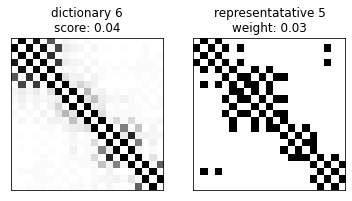

------- cluster 6, rep 5, pos in 22 -------
------- cluster 6, rep 19, pos in 23 -------


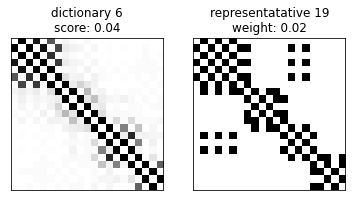

------- cluster 6, rep 19, pos in 23 -------
cluster : 15
------- cluster 15, rep 1, pos in 0 -------


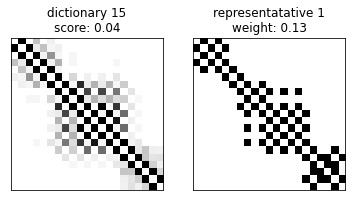

------- cluster 15, rep 1, pos in 0 -------
------- cluster 15, rep 9, pos in 1 -------


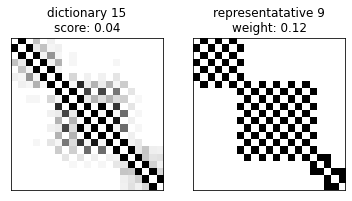

------- cluster 15, rep 9, pos in 1 -------
------- cluster 15, rep 6, pos in 2 -------


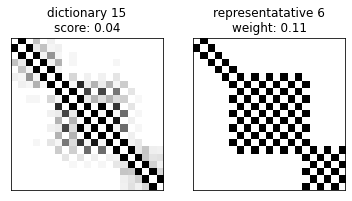

------- cluster 15, rep 6, pos in 2 -------
------- cluster 15, rep 3, pos in 3 -------


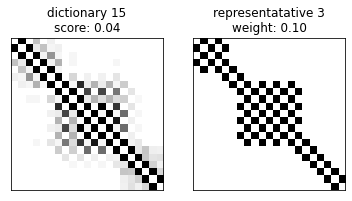

------- cluster 15, rep 3, pos in 3 -------
------- cluster 15, rep 4, pos in 4 -------


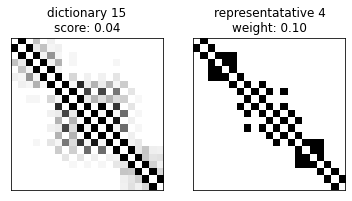

------- cluster 15, rep 4, pos in 4 -------
------- cluster 15, rep 10, pos in 5 -------


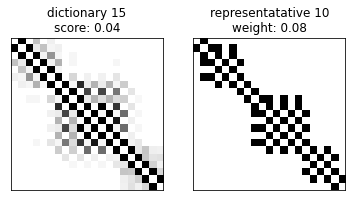

------- cluster 15, rep 10, pos in 5 -------
------- cluster 15, rep 8, pos in 6 -------


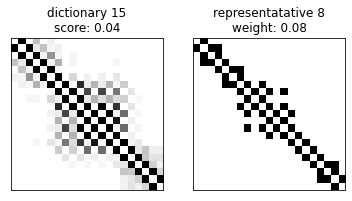

------- cluster 15, rep 8, pos in 6 -------
------- cluster 15, rep 2, pos in 7 -------


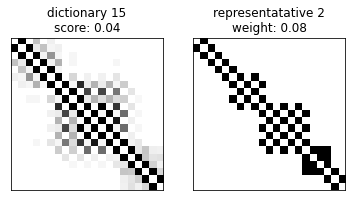

------- cluster 15, rep 2, pos in 7 -------
------- cluster 15, rep 0, pos in 8 -------


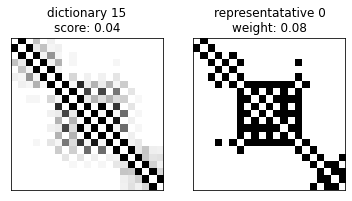

------- cluster 15, rep 0, pos in 8 -------
------- cluster 15, rep 7, pos in 9 -------


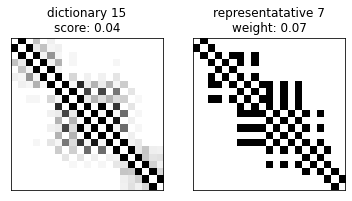

------- cluster 15, rep 7, pos in 9 -------
------- cluster 15, rep 5, pos in 10 -------


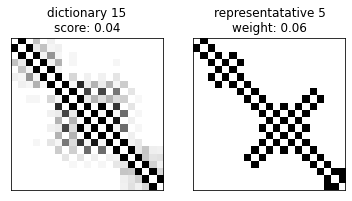

------- cluster 15, rep 5, pos in 10 -------
cluster : 3
------- cluster 3, rep 10, pos in 0 -------


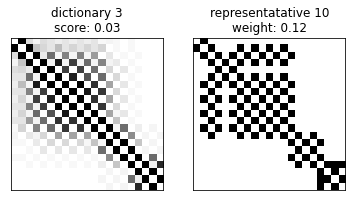

------- cluster 3, rep 10, pos in 0 -------
------- cluster 3, rep 3, pos in 1 -------


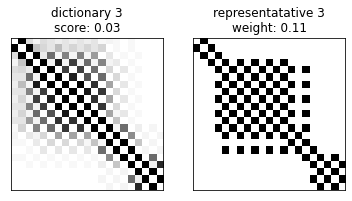

------- cluster 3, rep 3, pos in 1 -------
------- cluster 3, rep 4, pos in 2 -------


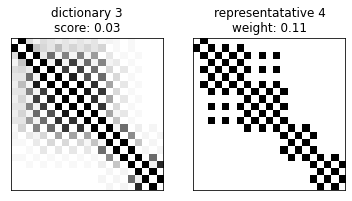

------- cluster 3, rep 4, pos in 2 -------
------- cluster 3, rep 0, pos in 3 -------


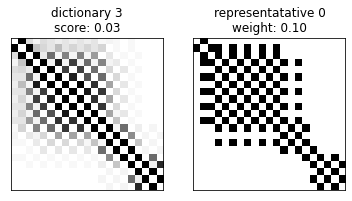

------- cluster 3, rep 0, pos in 3 -------
------- cluster 3, rep 6, pos in 4 -------


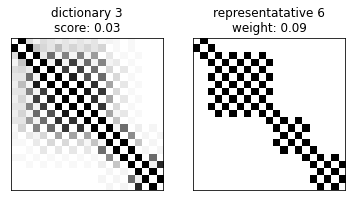

------- cluster 3, rep 6, pos in 4 -------
------- cluster 3, rep 1, pos in 5 -------


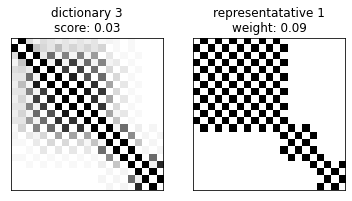

------- cluster 3, rep 1, pos in 5 -------
------- cluster 3, rep 2, pos in 6 -------


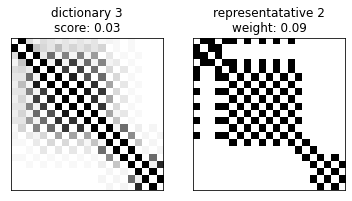

------- cluster 3, rep 2, pos in 6 -------
------- cluster 3, rep 8, pos in 7 -------


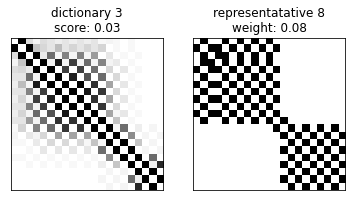

------- cluster 3, rep 8, pos in 7 -------
------- cluster 3, rep 5, pos in 8 -------


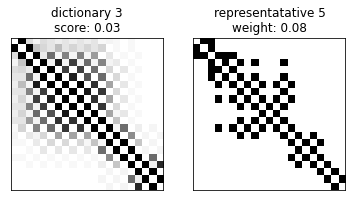

------- cluster 3, rep 5, pos in 8 -------
------- cluster 3, rep 9, pos in 9 -------


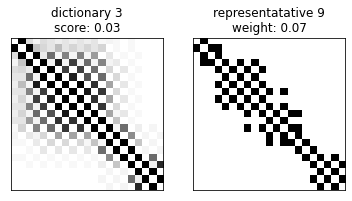

------- cluster 3, rep 9, pos in 9 -------
------- cluster 3, rep 7, pos in 10 -------


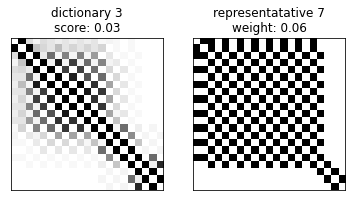

------- cluster 3, rep 7, pos in 10 -------
cluster : 18
------- cluster 18, rep 4, pos in 0 -------


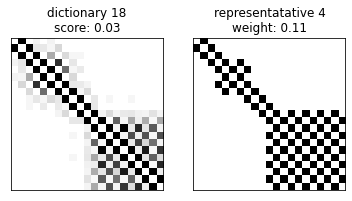

------- cluster 18, rep 4, pos in 0 -------
------- cluster 18, rep 1, pos in 1 -------


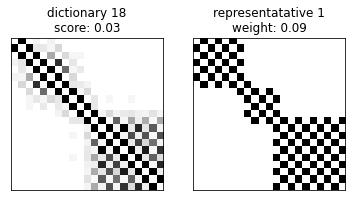

------- cluster 18, rep 1, pos in 1 -------
------- cluster 18, rep 2, pos in 2 -------


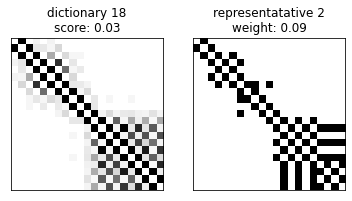

------- cluster 18, rep 2, pos in 2 -------
------- cluster 18, rep 3, pos in 3 -------


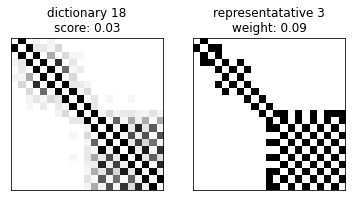

------- cluster 18, rep 3, pos in 3 -------
------- cluster 18, rep 9, pos in 4 -------


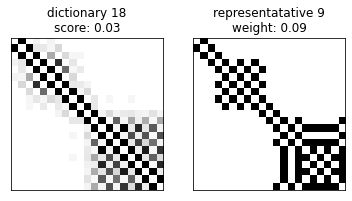

------- cluster 18, rep 9, pos in 4 -------
------- cluster 18, rep 6, pos in 5 -------


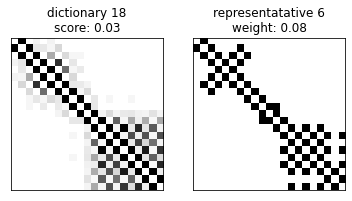

------- cluster 18, rep 6, pos in 5 -------
------- cluster 18, rep 10, pos in 6 -------


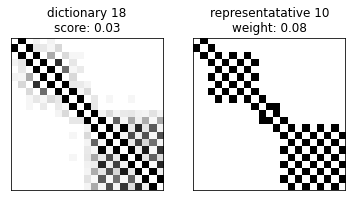

------- cluster 18, rep 10, pos in 6 -------
------- cluster 18, rep 8, pos in 7 -------


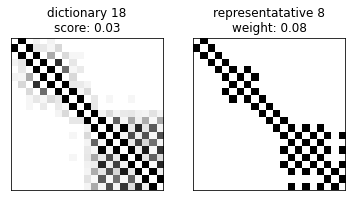

------- cluster 18, rep 8, pos in 7 -------
------- cluster 18, rep 11, pos in 8 -------


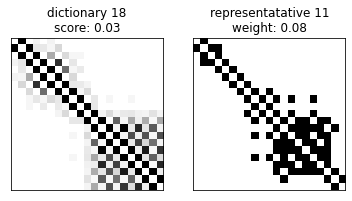

------- cluster 18, rep 11, pos in 8 -------
------- cluster 18, rep 5, pos in 9 -------


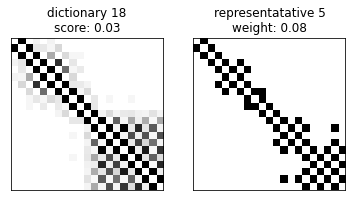

------- cluster 18, rep 5, pos in 9 -------
------- cluster 18, rep 7, pos in 10 -------


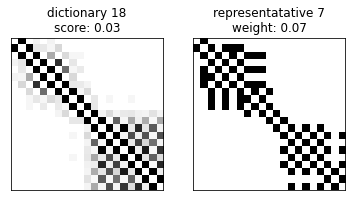

------- cluster 18, rep 7, pos in 10 -------
------- cluster 18, rep 0, pos in 11 -------


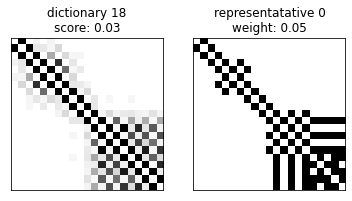

------- cluster 18, rep 0, pos in 11 -------
cluster : 16
------- cluster 16, rep 0, pos in 0 -------


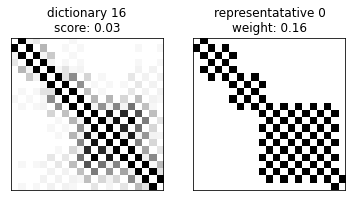

------- cluster 16, rep 0, pos in 0 -------
------- cluster 16, rep 7, pos in 1 -------


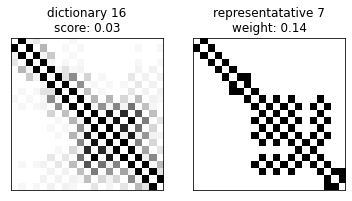

------- cluster 16, rep 7, pos in 1 -------
------- cluster 16, rep 4, pos in 2 -------


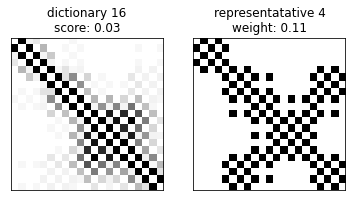

------- cluster 16, rep 4, pos in 2 -------
------- cluster 16, rep 1, pos in 3 -------


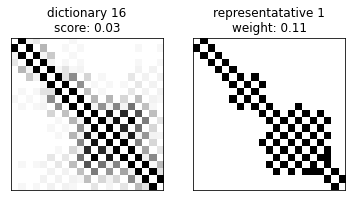

------- cluster 16, rep 1, pos in 3 -------
------- cluster 16, rep 6, pos in 4 -------


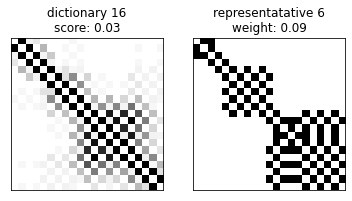

------- cluster 16, rep 6, pos in 4 -------
------- cluster 16, rep 9, pos in 5 -------


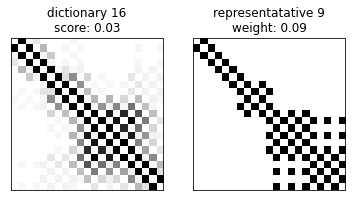

------- cluster 16, rep 9, pos in 5 -------
------- cluster 16, rep 3, pos in 6 -------


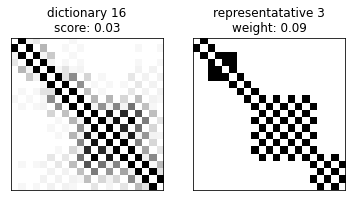

------- cluster 16, rep 3, pos in 6 -------
------- cluster 16, rep 8, pos in 7 -------


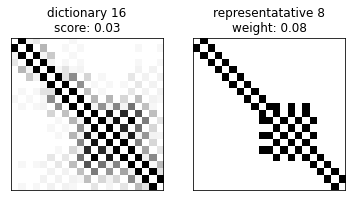

------- cluster 16, rep 8, pos in 7 -------
------- cluster 16, rep 5, pos in 8 -------


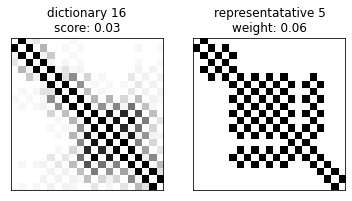

------- cluster 16, rep 5, pos in 8 -------
------- cluster 16, rep 2, pos in 9 -------


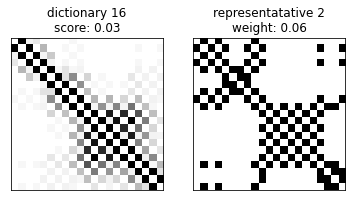

------- cluster 16, rep 2, pos in 9 -------
cluster : 12
------- cluster 12, rep 5, pos in 0 -------


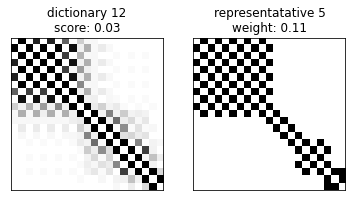

------- cluster 12, rep 5, pos in 0 -------
------- cluster 12, rep 7, pos in 1 -------


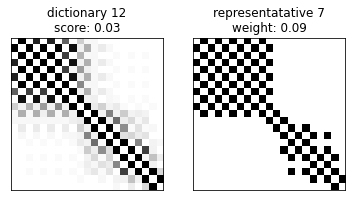

------- cluster 12, rep 7, pos in 1 -------
------- cluster 12, rep 2, pos in 2 -------


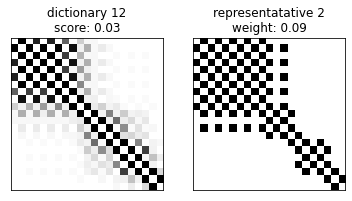

------- cluster 12, rep 2, pos in 2 -------
------- cluster 12, rep 13, pos in 3 -------


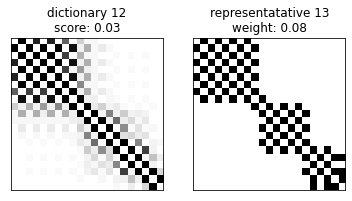

------- cluster 12, rep 13, pos in 3 -------
------- cluster 12, rep 9, pos in 4 -------


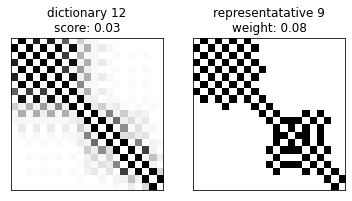

------- cluster 12, rep 9, pos in 4 -------
------- cluster 12, rep 8, pos in 5 -------


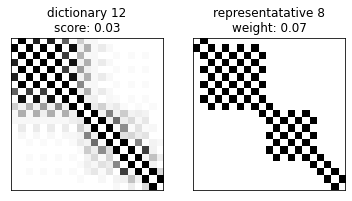

------- cluster 12, rep 8, pos in 5 -------
------- cluster 12, rep 10, pos in 6 -------


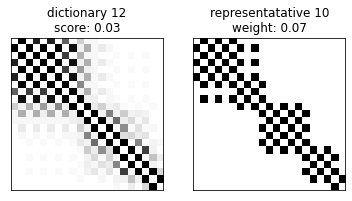

------- cluster 12, rep 10, pos in 6 -------
------- cluster 12, rep 6, pos in 7 -------


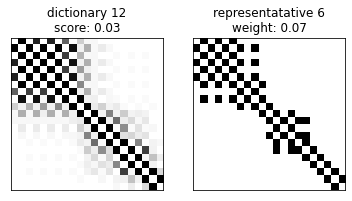

------- cluster 12, rep 6, pos in 7 -------
------- cluster 12, rep 4, pos in 8 -------


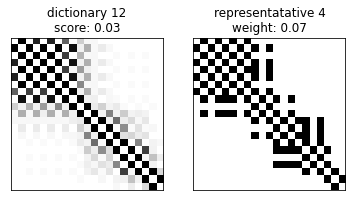

------- cluster 12, rep 4, pos in 8 -------
------- cluster 12, rep 3, pos in 9 -------


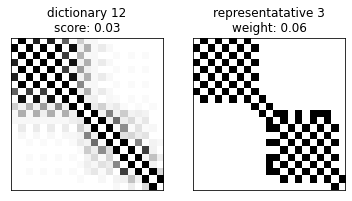

------- cluster 12, rep 3, pos in 9 -------
------- cluster 12, rep 11, pos in 10 -------


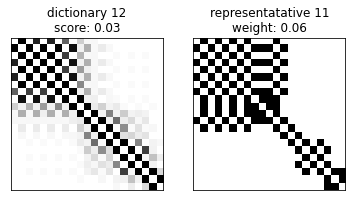

------- cluster 12, rep 11, pos in 10 -------
------- cluster 12, rep 0, pos in 11 -------


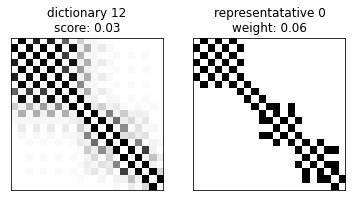

------- cluster 12, rep 0, pos in 11 -------
------- cluster 12, rep 12, pos in 12 -------


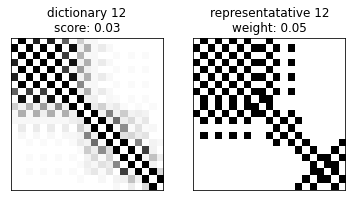

------- cluster 12, rep 12, pos in 12 -------
------- cluster 12, rep 1, pos in 13 -------


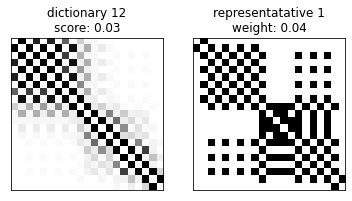

------- cluster 12, rep 1, pos in 13 -------
cluster : 24
------- cluster 24, rep 5, pos in 0 -------


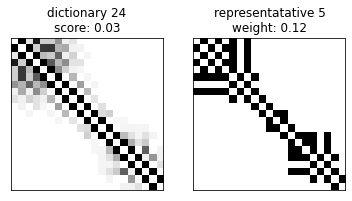

------- cluster 24, rep 5, pos in 0 -------
------- cluster 24, rep 2, pos in 1 -------


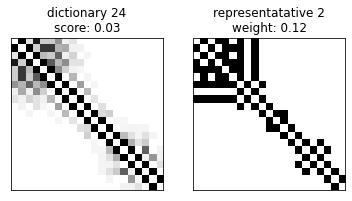

------- cluster 24, rep 2, pos in 1 -------
------- cluster 24, rep 6, pos in 2 -------


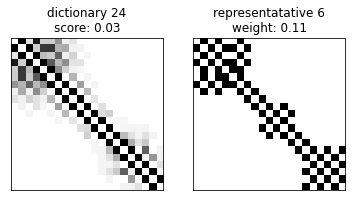

------- cluster 24, rep 6, pos in 2 -------
------- cluster 24, rep 4, pos in 3 -------


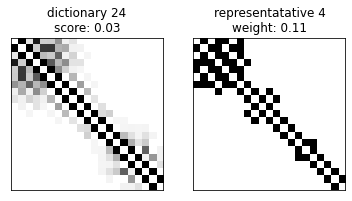

------- cluster 24, rep 4, pos in 3 -------
------- cluster 24, rep 9, pos in 4 -------


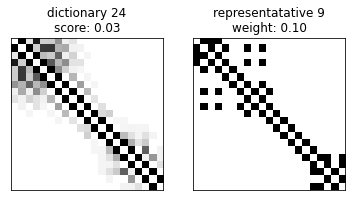

------- cluster 24, rep 9, pos in 4 -------
------- cluster 24, rep 7, pos in 5 -------


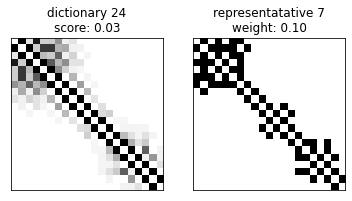

------- cluster 24, rep 7, pos in 5 -------
------- cluster 24, rep 0, pos in 6 -------


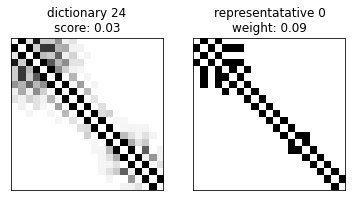

------- cluster 24, rep 0, pos in 6 -------
------- cluster 24, rep 8, pos in 7 -------


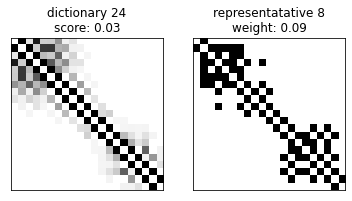

------- cluster 24, rep 8, pos in 7 -------
------- cluster 24, rep 1, pos in 8 -------


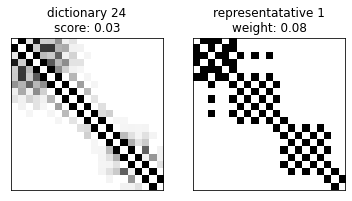

------- cluster 24, rep 1, pos in 8 -------
------- cluster 24, rep 3, pos in 9 -------


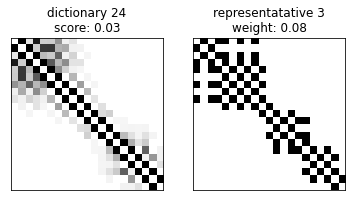

------- cluster 24, rep 3, pos in 9 -------
cluster : 20
------- cluster 20, rep 4, pos in 0 -------


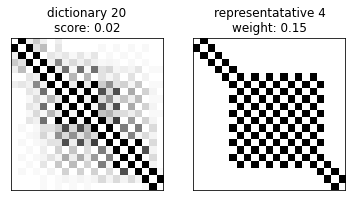

------- cluster 20, rep 4, pos in 0 -------
------- cluster 20, rep 2, pos in 1 -------


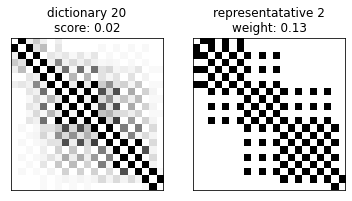

------- cluster 20, rep 2, pos in 1 -------
------- cluster 20, rep 8, pos in 2 -------


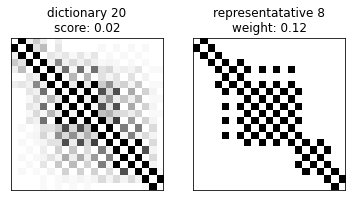

------- cluster 20, rep 8, pos in 2 -------
------- cluster 20, rep 6, pos in 3 -------


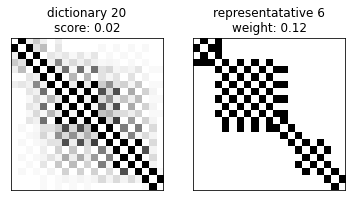

------- cluster 20, rep 6, pos in 3 -------
------- cluster 20, rep 3, pos in 4 -------


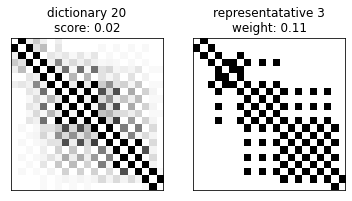

------- cluster 20, rep 3, pos in 4 -------
------- cluster 20, rep 9, pos in 5 -------


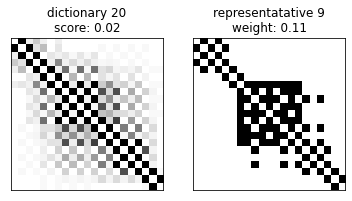

------- cluster 20, rep 9, pos in 5 -------
------- cluster 20, rep 0, pos in 6 -------


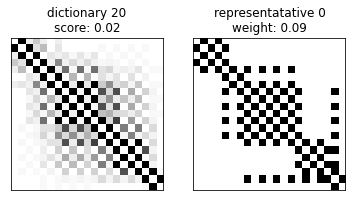

------- cluster 20, rep 0, pos in 6 -------
------- cluster 20, rep 7, pos in 7 -------


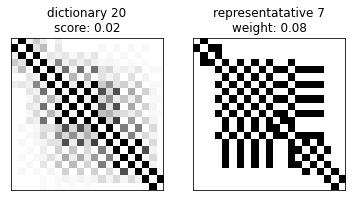

------- cluster 20, rep 7, pos in 7 -------
------- cluster 20, rep 1, pos in 8 -------


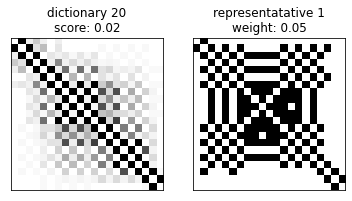

------- cluster 20, rep 1, pos in 8 -------
------- cluster 20, rep 5, pos in 9 -------


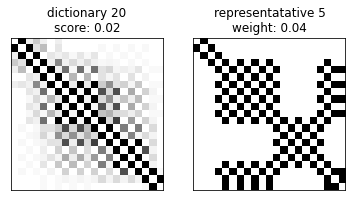

------- cluster 20, rep 5, pos in 9 -------
cluster : 11
------- cluster 11, rep 8, pos in 0 -------


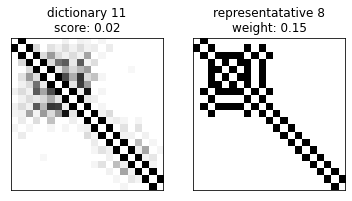

------- cluster 11, rep 8, pos in 0 -------
------- cluster 11, rep 7, pos in 1 -------


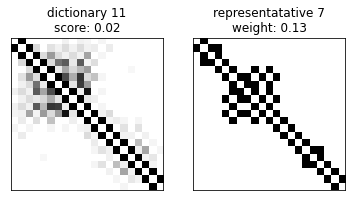

------- cluster 11, rep 7, pos in 1 -------
------- cluster 11, rep 2, pos in 2 -------


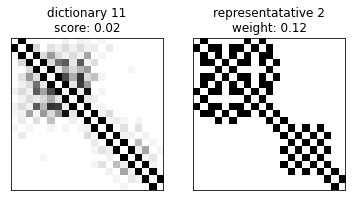

------- cluster 11, rep 2, pos in 2 -------
------- cluster 11, rep 5, pos in 3 -------


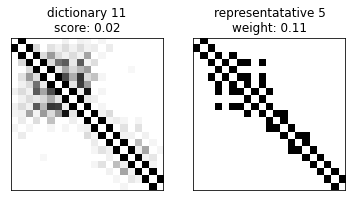

------- cluster 11, rep 5, pos in 3 -------
------- cluster 11, rep 3, pos in 4 -------


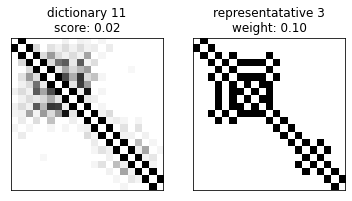

------- cluster 11, rep 3, pos in 4 -------
------- cluster 11, rep 1, pos in 5 -------


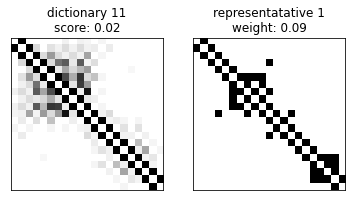

------- cluster 11, rep 1, pos in 5 -------
------- cluster 11, rep 4, pos in 6 -------


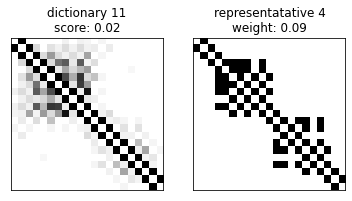

------- cluster 11, rep 4, pos in 6 -------
------- cluster 11, rep 9, pos in 7 -------


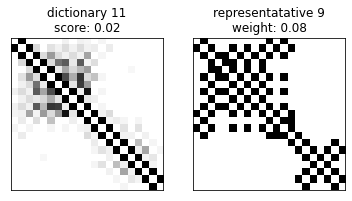

------- cluster 11, rep 9, pos in 7 -------
------- cluster 11, rep 6, pos in 8 -------


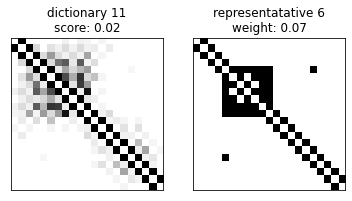

------- cluster 11, rep 6, pos in 8 -------
------- cluster 11, rep 0, pos in 9 -------


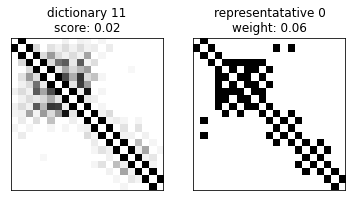

------- cluster 11, rep 0, pos in 9 -------
cluster : 1
------- cluster 1, rep 1, pos in 0 -------


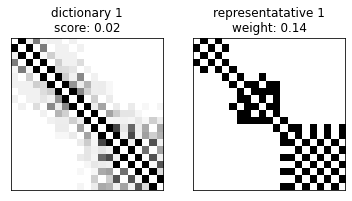

------- cluster 1, rep 1, pos in 0 -------
------- cluster 1, rep 9, pos in 1 -------


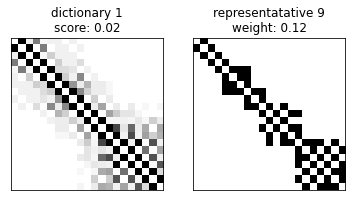

------- cluster 1, rep 9, pos in 1 -------
------- cluster 1, rep 2, pos in 2 -------


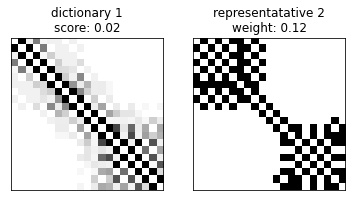

------- cluster 1, rep 2, pos in 2 -------
------- cluster 1, rep 7, pos in 3 -------


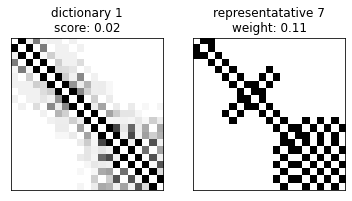

------- cluster 1, rep 7, pos in 3 -------
------- cluster 1, rep 3, pos in 4 -------


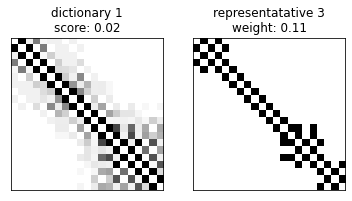

------- cluster 1, rep 3, pos in 4 -------
------- cluster 1, rep 0, pos in 5 -------


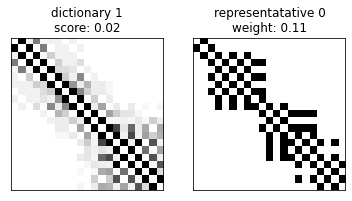

------- cluster 1, rep 0, pos in 5 -------
------- cluster 1, rep 5, pos in 6 -------


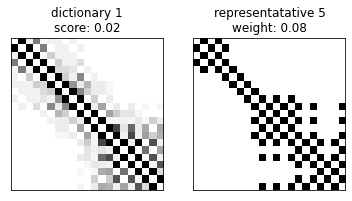

------- cluster 1, rep 5, pos in 6 -------
------- cluster 1, rep 4, pos in 7 -------


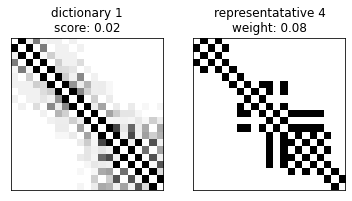

------- cluster 1, rep 4, pos in 7 -------
------- cluster 1, rep 6, pos in 8 -------


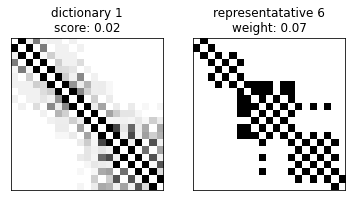

------- cluster 1, rep 6, pos in 8 -------
------- cluster 1, rep 8, pos in 9 -------


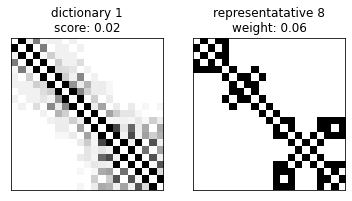

------- cluster 1, rep 8, pos in 9 -------
cluster : 10
------- cluster 10, rep 5, pos in 0 -------


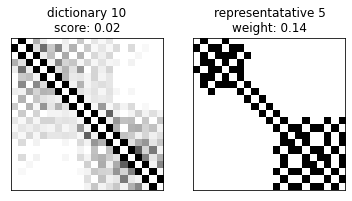

------- cluster 10, rep 5, pos in 0 -------
------- cluster 10, rep 7, pos in 1 -------


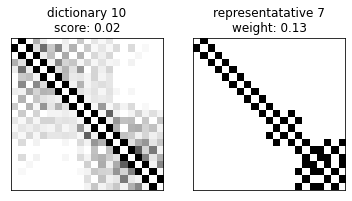

------- cluster 10, rep 7, pos in 1 -------
------- cluster 10, rep 0, pos in 2 -------


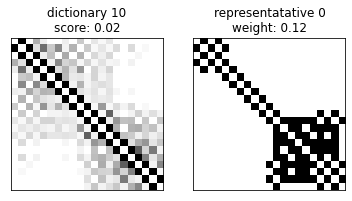

------- cluster 10, rep 0, pos in 2 -------
------- cluster 10, rep 1, pos in 3 -------


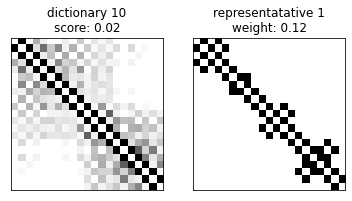

------- cluster 10, rep 1, pos in 3 -------
------- cluster 10, rep 8, pos in 4 -------


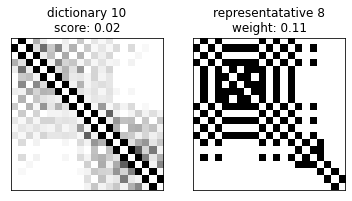

------- cluster 10, rep 8, pos in 4 -------
------- cluster 10, rep 6, pos in 5 -------


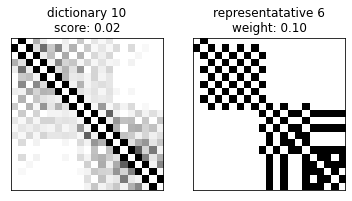

------- cluster 10, rep 6, pos in 5 -------
------- cluster 10, rep 3, pos in 6 -------


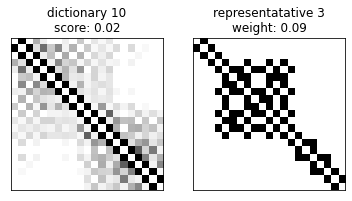

------- cluster 10, rep 3, pos in 6 -------
------- cluster 10, rep 4, pos in 7 -------


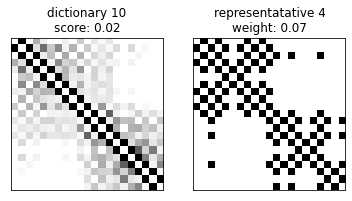

------- cluster 10, rep 4, pos in 7 -------
------- cluster 10, rep 9, pos in 8 -------


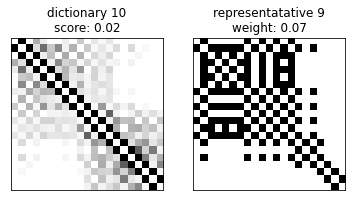

------- cluster 10, rep 9, pos in 8 -------
------- cluster 10, rep 2, pos in 9 -------


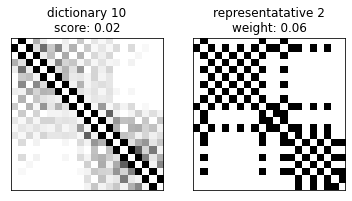

------- cluster 10, rep 2, pos in 9 -------
cluster : 9
------- cluster 9, rep 0, pos in 0 -------


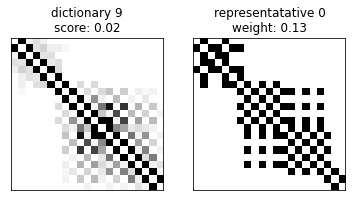

------- cluster 9, rep 0, pos in 0 -------
------- cluster 9, rep 6, pos in 1 -------


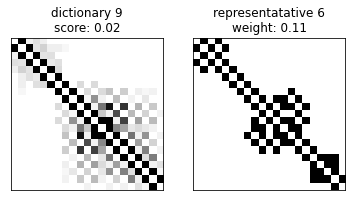

------- cluster 9, rep 6, pos in 1 -------
------- cluster 9, rep 5, pos in 2 -------


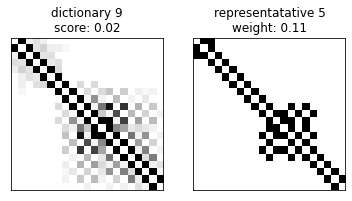

------- cluster 9, rep 5, pos in 2 -------
------- cluster 9, rep 4, pos in 3 -------


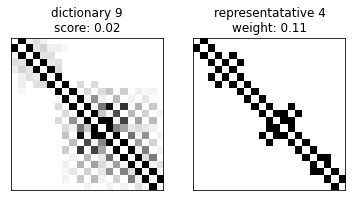

------- cluster 9, rep 4, pos in 3 -------
------- cluster 9, rep 1, pos in 4 -------


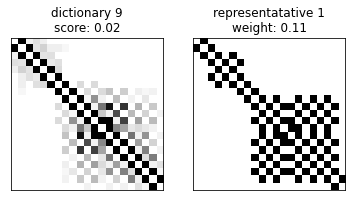

------- cluster 9, rep 1, pos in 4 -------
------- cluster 9, rep 9, pos in 5 -------


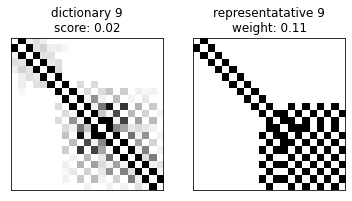

------- cluster 9, rep 9, pos in 5 -------
------- cluster 9, rep 3, pos in 6 -------


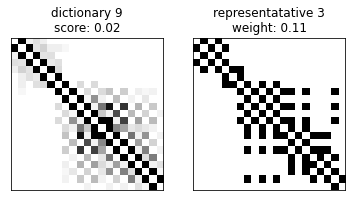

------- cluster 9, rep 3, pos in 6 -------
------- cluster 9, rep 2, pos in 7 -------


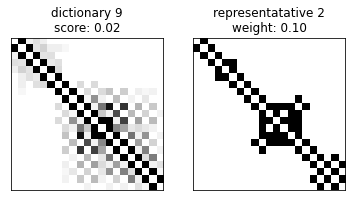

------- cluster 9, rep 2, pos in 7 -------
------- cluster 9, rep 7, pos in 8 -------


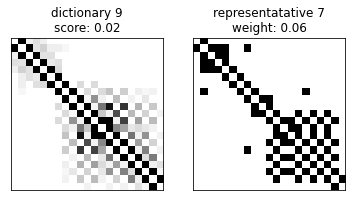

------- cluster 9, rep 7, pos in 8 -------
------- cluster 9, rep 8, pos in 9 -------


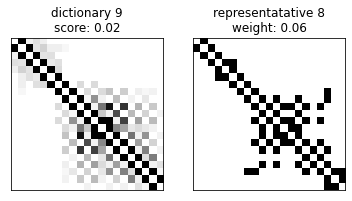

------- cluster 9, rep 8, pos in 9 -------
cluster : 19
------- cluster 19, rep 2, pos in 0 -------


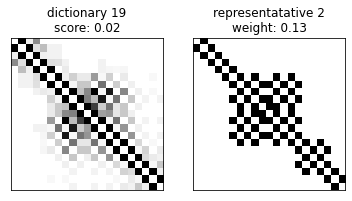

------- cluster 19, rep 2, pos in 0 -------
------- cluster 19, rep 6, pos in 1 -------


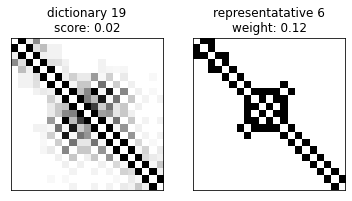

------- cluster 19, rep 6, pos in 1 -------
------- cluster 19, rep 7, pos in 2 -------


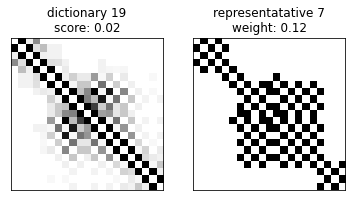

------- cluster 19, rep 7, pos in 2 -------
------- cluster 19, rep 5, pos in 3 -------


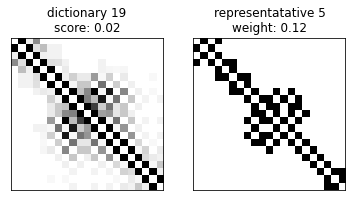

------- cluster 19, rep 5, pos in 3 -------
------- cluster 19, rep 8, pos in 4 -------


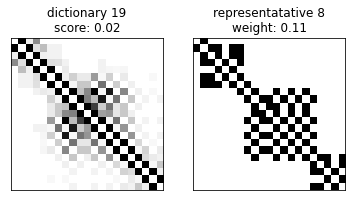

------- cluster 19, rep 8, pos in 4 -------
------- cluster 19, rep 0, pos in 5 -------


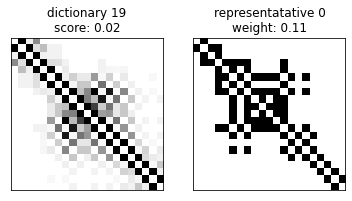

------- cluster 19, rep 0, pos in 5 -------
------- cluster 19, rep 4, pos in 6 -------


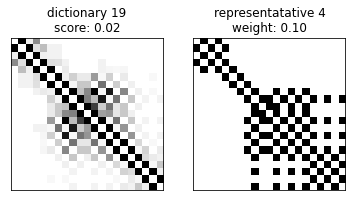

------- cluster 19, rep 4, pos in 6 -------
------- cluster 19, rep 3, pos in 7 -------


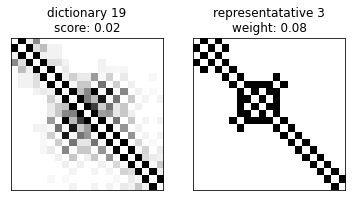

------- cluster 19, rep 3, pos in 7 -------
------- cluster 19, rep 1, pos in 8 -------


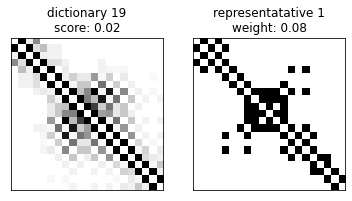

------- cluster 19, rep 1, pos in 8 -------
------- cluster 19, rep 9, pos in 9 -------


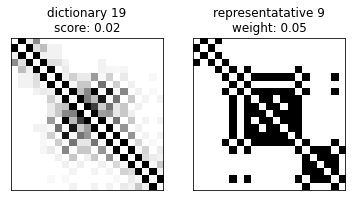

------- cluster 19, rep 9, pos in 9 -------
cluster : 13
------- cluster 13, rep 8, pos in 0 -------


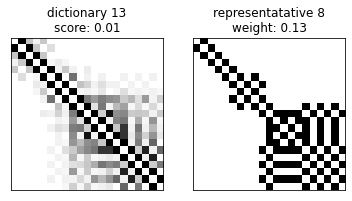

------- cluster 13, rep 8, pos in 0 -------
------- cluster 13, rep 9, pos in 1 -------


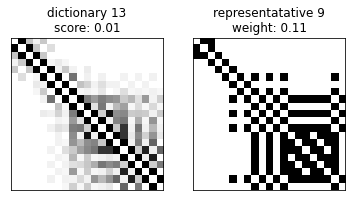

------- cluster 13, rep 9, pos in 1 -------
------- cluster 13, rep 3, pos in 2 -------


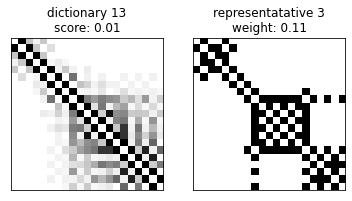

------- cluster 13, rep 3, pos in 2 -------
------- cluster 13, rep 1, pos in 3 -------


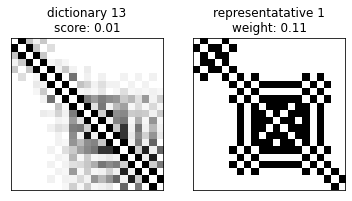

------- cluster 13, rep 1, pos in 3 -------
------- cluster 13, rep 5, pos in 4 -------


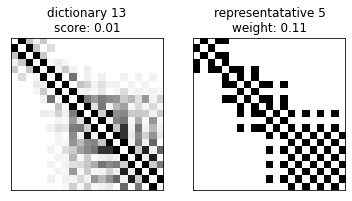

------- cluster 13, rep 5, pos in 4 -------
------- cluster 13, rep 0, pos in 5 -------


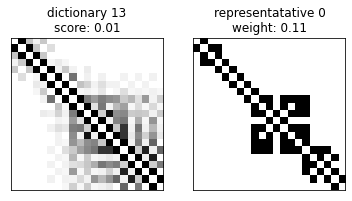

------- cluster 13, rep 0, pos in 5 -------
------- cluster 13, rep 7, pos in 6 -------


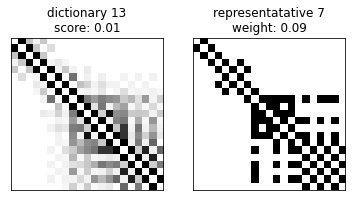

------- cluster 13, rep 7, pos in 6 -------
------- cluster 13, rep 2, pos in 7 -------


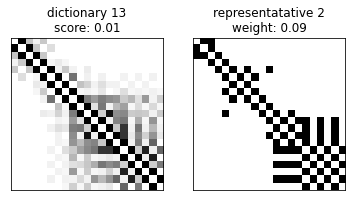

------- cluster 13, rep 2, pos in 7 -------
------- cluster 13, rep 6, pos in 8 -------


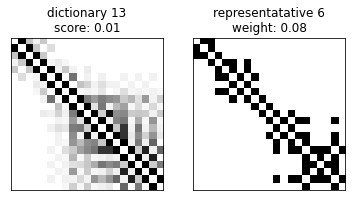

------- cluster 13, rep 6, pos in 8 -------
------- cluster 13, rep 4, pos in 9 -------


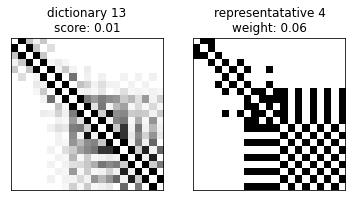

------- cluster 13, rep 4, pos in 9 -------
cluster : 23
------- cluster 23, rep 8, pos in 0 -------


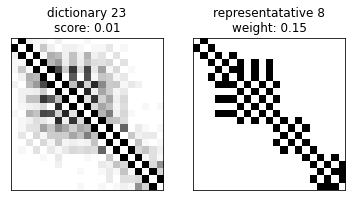

------- cluster 23, rep 8, pos in 0 -------
------- cluster 23, rep 4, pos in 1 -------


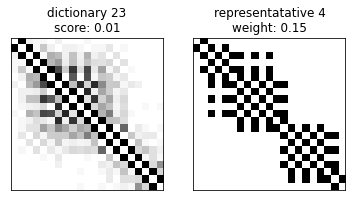

------- cluster 23, rep 4, pos in 1 -------
------- cluster 23, rep 0, pos in 2 -------


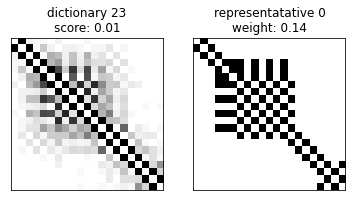

------- cluster 23, rep 0, pos in 2 -------
------- cluster 23, rep 5, pos in 3 -------


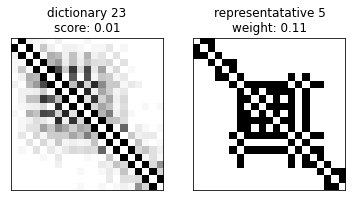

------- cluster 23, rep 5, pos in 3 -------
------- cluster 23, rep 6, pos in 4 -------


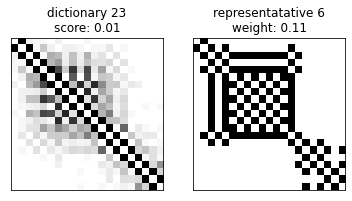

------- cluster 23, rep 6, pos in 4 -------
------- cluster 23, rep 7, pos in 5 -------


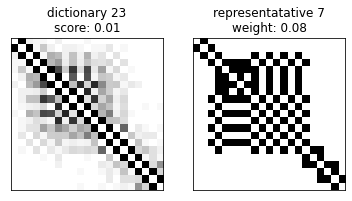

------- cluster 23, rep 7, pos in 5 -------
------- cluster 23, rep 3, pos in 6 -------


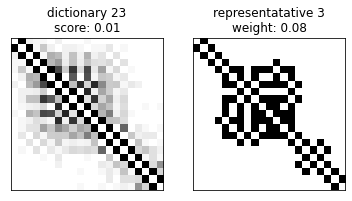

------- cluster 23, rep 3, pos in 6 -------
------- cluster 23, rep 2, pos in 7 -------


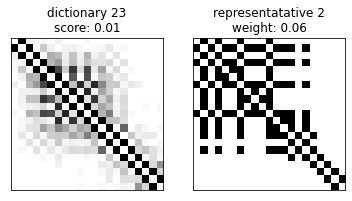

------- cluster 23, rep 2, pos in 7 -------
------- cluster 23, rep 1, pos in 8 -------


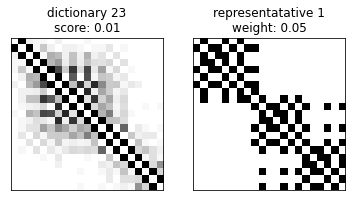

------- cluster 23, rep 1, pos in 8 -------
------- cluster 23, rep 9, pos in 9 -------


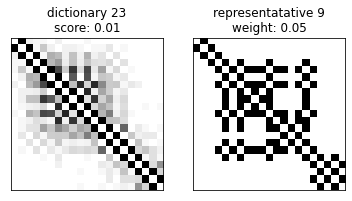

------- cluster 23, rep 9, pos in 9 -------


In [38]:
for cluster in descending_order_of_At:
    cur_importance_score = importance_score[cluster]
    # get current dictionary row from for the current cluster with descending importance score.
    dict_row = ocmf_dict[ocmf_dict.label == f'ocmf: type {cluster + 1}']
    dict_row = dict_row[feature]
    
    # get representative regions for the current cluster.
    cur_label = f'group {cluster}'
    df_rep_val_df = rep_region[rep_region.label == cur_label].drop(columns = ['label'])
    
    # Find convex weight for each rep. in the corresponding column of cvx_weight, and the selected 
    # representative rows. 
    # df_W_hat is a column vector matrix. Each column is the weight for a cluster.
    cvx_weight = df_W_hat[rep_region.label == cur_label].values[:, cluster]
    descending_order_cvx_weight = cvx_weight.argsort()[::-1]
    
    # sort representative by their cvx weights. 
    sorted_df_rep_val_df_by_cvx_weight = df_rep_val_df.iloc[descending_order_cvx_weight]
    print('cluster :', cluster)
    
    for idx, (_, row) in enumerate(sorted_df_rep_val_df_by_cvx_weight.iterrows()):

        row_in = row.values
        cur_rep_idx = descending_order_cvx_weight[idx]
        cur_weight = cvx_weight[cur_rep_idx]
        
        print('-' * 7, f'cluster {cluster}, rep {cur_rep_idx}, pos in {idx}', '-' * 7)
        
        if warning_flag:
            # even though used old dataset, try to find if matching in new dataset exists.
            # always true: df_raw_data == X_df != df_raw_data_matched_emb
            sample_idx_in_subgraphs = (df_raw_data_matched_emb == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data_matched_emb.loc[sample_idx_in_subgraphs]
            
            if len(samples_from_df_raw_data) == 0:
#                 print('no match of row adj in new dataset with embedding. Use OLD dataset')
                sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
                samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
                
            
        else:
            # no warning sign. we are using new dataset so there is no error.
            # df_raw_data == X_df == df_raw_data_matched_emb.
            sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
        
        # In case there are multiple samples with same weight matrices, select the first one.
        samples_from_df_raw_data = samples_from_df_raw_data.iloc[0]
        
# ----------
#         tmp_samples_from_df_raw_data_matched_emb = df_raw_data_matched_emb.loc[sample_idx_in_subgraphs]                
#         sample_diff = np.sum(abs(samples_from_df_raw_data - tmp_samples_from_df_raw_data_matched_emb).values)
#         if sample_diff > 0:
#             pass
# #             print(f'sample difference in old dataset and new dataset for the same row_in: {sample_diff}')
# #             titles = ['row in new dataset', 'row in old dataset']
# #             plot_two_rows(tmp_samples_from_df_raw_data_matched_emb, 
# #                          samples_from_df_raw_data, 
# #                          titles)
# ----------

        # In each cluster, for each representative, draw the dictionary, and the representative.
        titles = [f'dictionary {cluster}\nscore: {cur_importance_score:.2f}', 
                  f'representatative {cur_rep_idx}\nweight: {cur_weight:.2f}']
        plot_two_rows(dict_row, samples_from_df_raw_data, titles)
        
        
        # Get node embeddings. 
        node_embedding_of_samples = df_node_all.loc[sample_idx_in_subgraphs].iloc[0].values
        
        # Create networkx graph from the samples adjacency matrix. 
        Adj = samples_from_df_raw_data.values.reshape(21, 21)
        G = nx.from_numpy_matrix(Adj, )
        
        # Each node has its node embedding id, from: node_embedding_of_samples
        node_name_map = {x:node_embedding_of_samples[x] for x in range(len(node_embedding_of_samples))}
        G = nx.relabel.relabel_nodes(G, node_name_map)
        
        # Get nodes and edges from G, reorder nodes by ascending order of node embedding. 
        nodes = list(G.nodes(data = True))
        edges = list(G.edges(data = True))
        
        node_pos = np.array([int(x[0][1:]) for x in nodes])
        new_node_order = node_pos.argsort()
        
        new_node_pos = node_pos[new_node_order]
        new_nodes = [nodes[i] for i in new_node_order]
        
        # create position for reordered nodes.
        min_node_pos = min(new_node_pos)
        max_node_pos = max(new_node_pos)
        node_pos_span = max_node_pos - min_node_pos

        pos = {new_nodes[i][0] : ((new_node_pos[i] - min_node_pos) / node_pos_span * 100, 0) \
               for i in range(len(nodes))}
        
        # change edges to same order between two vertices. i.e. n1 > n2.
        backward_edge = lambda edge: (int(edge[0][1:]) < int(edge[1][1:]))
        flip_nodes = lambda edge: (edge[1], edge[0], edge[2]) if backward_edge(edge) else edge
        new_edges = [flip_nodes(x) for x in edges]
        
        # Create new graph H, from the new nodes, and same edges as G. 
        H_directed = nx.DiGraph()
        H_directed.add_nodes_from(new_nodes)
        H_directed.add_edges_from(new_edges)
        
        p2saved = f'/data/shared/jianhao/online_cvxNDL_results/{chromo}/representatvies_edge_list_updated_0905_MCMC_pivot_train_iter_10k/dictionary_{cluster}'
        if not osp.isdir(p2saved):
            os.makedirs(p2saved)
        draw_arc_of_graph(H_directed, pos, 
                          p2savefig=osp.join(p2saved, 
                                             f'arc_plot_dictionary_{cluster}_rep_{cur_rep_idx}'))
        plt.close()
        
        p2edge_list = osp.join(p2saved, 
                              f'edge_list_dicitonary_{cluster}_rep_{cur_rep_idx}.txt')
        with open(p2edge_list, 'w') as f:
            for line in new_edges:
                f.write(','.join(line[:2]))
                f.write('\n')
        
        print('-' * 7, f'cluster {cluster}, rep {cur_rep_idx}, pos in {idx}', '-' * 7)
        
#         break
#     break
    

In [39]:
new_edges

[('V35160', 'V34770', {'weight': 1.0}),
 ('V34770', 'V15998', {'weight': 1.0}),
 ('V33392', 'V15998', {'weight': 1.0}),
 ('V34964', 'V33392', {'weight': 1.0}),
 ('V34964', 'V18758', {'weight': 1.0}),
 ('V34977', 'V34964', {'weight': 1.0}),
 ('V34964', 'V34939', {'weight': 1.0}),
 ('V34964', 'V22158', {'weight': 1.0}),
 ('V40836', 'V34964', {'weight': 1.0}),
 ('V34964', 'V31698', {'weight': 1.0}),
 ('V34977', 'V34939', {'weight': 1.0}),
 ('V40836', 'V22158', {'weight': 1.0}),
 ('V40836', 'V7423', {'weight': 1.0}),
 ('V38266', 'V31698', {'weight': 1.0}),
 ('V38266', 'V8120', {'weight': 1.0}),
 ('V38266', 'V17916', {'weight': 1.0})]

# randomly select original samples as representatives for each dictionary.

In [40]:
df_raw_data

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_431,dim_432,dim_433,dim_434,dim_435,dim_436,dim_437,dim_438,dim_439,dim_440
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
19996,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [41]:
df_node_all

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,node_11,node_12,node_13,node_14,node_15,node_16,node_17,node_18,node_19,node_20
0,V5997,V19835,V969,V961,V2405,V20728,V20814,V20728,V26131,V20728,...,V20728,V27017,V6131,V11815,V4455,V11815,V6131,V4455,V27017,V27025
1,V41207,V22040,V41207,V22040,V41207,V22040,V36348,V41207,V22040,V20407,...,V4078,V186,V250,V135,V14276,V135,V19913,V135,V186,V153
2,V13615,V16412,V16377,V14431,V16377,V16412,V16400,V16412,V16256,V14432,...,V44859,V41989,V14432,V15932,V41989,V15932,V27666,V41754,V41780,V41767
3,V7474,V7462,V87,V16766,V2911,V1000,V1035,V35092,V35449,V35092,...,V6371,V35017,V1035,V1000,V954,V19311,V9257,V42290,V42241,V34944
4,V7474,V7462,V5357,V4394,V5357,V7462,V7497,V16411,V39787,V500,...,V39428,V39553,V39351,V39428,V25400,V25623,V258,V27057,V34954,V3538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,V39624,V42442,V2820,V18992,V7395,V18992,V16630,V12679,V1020,V1083,...,V36334,V4157,V36334,V37139,V969,V16023,V969,V35164,V969,V218
19996,V26447,V27659,V27672,V19229,V43360,V34901,V324,V6740,V324,V32512,...,V16411,V27231,V26418,V10942,V20765,V32906,V32787,V33273,V41480,V31699
19997,V39599,V9995,V38842,V16847,V4306,V1057,V985,V42527,V42478,V13003,...,V29664,V33223,V33250,V27114,V27156,V20854,V20824,V33868,V20856,V14348
19998,V39954,V9995,V10131,V9998,V27680,V9998,V1665,V1656,V1665,V1644,...,V38189,V1280,V2259,V18030,V2259,V2117,V2243,V2117,V2259,V2251


In [42]:
for cluster in descending_order_of_At:
    
    for cur_rep_idx in range(10):
        random_idx = np.random.choice(len(df_raw_data))
        samples_from_df_raw_data = df_raw_data.loc[random_idx]
        
        # Get node embeddings. 
        node_embedding_of_samples = df_node_all.loc[random_idx]
        
        # Create networkx graph from the samples adjacency matrix. 
        Adj = samples_from_df_raw_data.values.reshape(21, 21)
        G = nx.from_numpy_matrix(Adj, )
        
        # Each node has its node embedding id, from: node_embedding_of_samples
        node_name_map = {x:node_embedding_of_samples[x] for x in range(len(node_embedding_of_samples))}
        G = nx.relabel.relabel_nodes(G, node_name_map)
        
        # Get nodes and edges from G, reorder nodes by ascending order of node embedding. 
        nodes = list(G.nodes(data = True))
        edges = list(G.edges(data = True))
        
        node_pos = np.array([int(x[0][1:]) for x in nodes])
        new_node_order = node_pos.argsort()
        
        new_node_pos = node_pos[new_node_order]
        new_nodes = [nodes[i] for i in new_node_order]
        
        # create position for reordered nodes.
        min_node_pos = min(new_node_pos)
        max_node_pos = max(new_node_pos)
        node_pos_span = max_node_pos - min_node_pos

        pos = {new_nodes[i][0] : ((new_node_pos[i] - min_node_pos) / node_pos_span * 100, 0) \
               for i in range(len(nodes))}
        
        # change edges to same order between two vertices. i.e. n1 > n2.
        backward_edge = lambda edge: (int(edge[0][1:]) < int(edge[1][1:]))
        flip_nodes = lambda edge: (edge[1], edge[0], edge[2]) if backward_edge(edge) else edge
        new_edges = [flip_nodes(x) for x in edges]
        
        # Create new graph H, from the new nodes, and same edges as G. 
        H_directed = nx.DiGraph()
        H_directed.add_nodes_from(new_nodes)
        H_directed.add_edges_from(new_edges)
        
        p2saved = f'/data/shared/jianhao/online_cvxNDL_results/{chromo}/random_rep_edge_list/dictionary_{cluster}'
        if not osp.isdir(p2saved):
            os.makedirs(p2saved)
        draw_arc_of_graph(H_directed, pos, 
                          p2savefig=osp.join(p2saved, 
                                             f'arc_plot_dictionary_{cluster}_rep_{cur_rep_idx}'))
        plt.close()
        
        p2edge_list = osp.join(p2saved, 
                              f'edge_list_dicitonary_{cluster}_rep_{cur_rep_idx}.txt')
        with open(p2edge_list, 'w') as f:
            for line in new_edges:
                f.write(','.join(line[:2]))
                f.write('\n')
        
        
#         break
#     break
    

In [43]:
random_idx

332